Based on https://github.com/siyi-wind/TIP/tree/main/data/create_dvm_dataset.ipynb

In [1]:
import os
import torch
import operator
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from scipy.special import kl_div
from typing import Union, Tuple, Dict, Any
from scipy.spatial.distance import jensenshannon
from sklearn.model_selection import train_test_split

In [2]:
BASE = "/mnt/data/kgutjahr/datasets/DVM"
TABLES= os.path.join(BASE, "tables")
FEATURES = os.path.join(BASE, "images")
SHIFTED_DIR = os.path.join(BASE, "shifted_dists")

In [3]:
color_coding = {0: 'Beige',
                1: 'Black',
                2: 'Blue', 
                3: 'Bronze', 
                4: 'Brown', 
                5: 'Burgundy', 
                6: 'Gold', 
                7: 'Green', 
                8: 'Grey', 
                9: 'Indigo', 
                10: 'Magenta', 
                11: 'Maroon', 
                12: 'Multicolour', 
                13: 'Navy', 
                14: 'Orange', 
                15: 'Pink', 
                16: 'Purple', 
                17: 'Red', 
                18: 'Silver', 
                19: 'Turquoise', 
                20: 'White', 
                21: 'Yellow'}

In [79]:
def get_counts(df: pd.DataFrame, feature: str) -> pd.DataFrame:
    counts = df[feature].value_counts()
    percentages = df[feature].value_counts(normalize=True) * 100

    # Optional: Combine into one DataFrame for clarity
    summary = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages.round(3)
    })
    return summary

In [5]:
def plot_color_distributions(df: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 6))
    ax = df["Count"].plot(kind='bar', color='skyblue', edgecolor='black', width=1)

    # Customize the plot
    plt.title('Color distribution')
    plt.xlabel('Colors')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, fontsize=10)  # Rotate labels for better readability
    plt.tight_layout()

    # Show the plot
    plt.show()

In [141]:
def plot_distributions_compare(train_df: pd.Series, val_df: pd.Series, test_df: pd.Series, feature: str,bins: int = 50) -> None:
    plt.figure(figsize=(10, 6))

    # Plot histograms on the same axis
    plt.hist(train_df.dropna(), bins=bins, alpha=0.5, label='Train', color='skyblue', edgecolor='black')
    plt.hist(val_df.dropna(),   bins=bins, alpha=0.5, label='Val',   color='salmon', edgecolor='black')
    plt.hist(test_df.dropna(),  bins=bins, alpha=0.5, label='Test',  color='limegreen', edgecolor='black')

    # Customize
    plt.title(f'{feature} Distribution Comparison')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def fill_missing_vals(df: pd.DataFrame, fill_values: list[str]) -> pd.DataFrame:
    # fill missing color with 0 if it isn't present in distribution
    for fill in fill_values:
        if fill not in df:
            df[fill] = 0
    return df

In [97]:
def calc_JS(first_dist: pd.DataFrame, second_dist: pd.DataFrame) -> float:
    first_sorted = first_dist.sort_index()
    second_sorted = second_dist.sort_index()
    js = jensenshannon(first_sorted, second_sorted)
    return float(js)

# Get entire Dataset

In [8]:
physical_df = pd.read_csv(os.path.join(TABLES,'Ad_table_physical_filled_jittered_50.csv'))[['Adv_ID', 'Wheelbase','Height','Width','Length']]
physical_df

,Adv_ID,Wheelbase,Height,Width,Length
0,10_1$$1,3134.0,1534.0,2118.0,5387.0
1,10_1$$2,3102.0,1551.0,2075.0,5433.0
2,10_1$$3,3122.0,1490.0,2122.0,5369.0
3,10_1$$4,3135.0,1513.0,2094.0,5353.0
4,10_1$$5,3105.0,1514.0,2077.0,5376.0
...,...,...,...,...,...
268250,97_1$$1,NaN,NaN,NaN,NaN
268251,97_1$$2,NaN,NaN,NaN,NaN
268252,99_1$$1,NaN,NaN,NaN,NaN
268253,99_1$$2,NaN,NaN,NaN,NaN


In [9]:
ad_data = pd.read_csv(os.path.join(TABLES, 'Ad_table.csv'))[['Adv_ID', 'Genmodel', "Maker"]]
ad_data

/tmp/ipykernel_974785/3060315506.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ad_data = pd.read_csv(os.path.join(TABLES, 'Ad_table.csv'))[['Adv_ID', 'Genmodel', "Maker"]]


,Adv_ID,Genmodel,Maker
0,10_1$$1,Arnage,Bentley
1,10_1$$2,Arnage,Bentley
2,10_1$$3,Arnage,Bentley
3,10_1$$4,Arnage,Bentley
4,10_1$$5,Arnage,Bentley
...,...,...,...
268250,97_1$$1,Sport,Westfield
268251,97_1$$2,Sport,Westfield
268252,99_1$$1,E10,Zenos
268253,99_1$$2,E10,Zenos


In [10]:
unique_cars = ad_data.drop_duplicates(subset=["Maker", "Genmodel"]).reset_index(drop=True)
unique_cars['Genmodel_ID'] = unique_cars['Adv_ID'].str.partition('$$')[0]
unique_cars['Car Name'] = unique_cars['Maker'].str.cat(unique_cars['Genmodel'], sep=' ')
unique_cars.drop(["Maker", "Genmodel", "Adv_ID"], axis=1, inplace=True)

unique_cars

,Genmodel_ID,Car Name
0,10_1,Bentley Arnage
1,10_2,Bentley Azure
2,10_3,Bentley Bentayga
3,10_4,Bentley Brooklands
4,10_5,Bentley Continental
...,...,...
911,96_7,Volvo V40
912,96_8,Volvo V40 Cross Country
913,96_9,Volvo V50
914,97_1,Westfield Sport


In [11]:
data_path = os.path.join(FEATURES, "data_df_unnorm.csv")
full_data_df = pd.read_csv(data_path)
full_data_df = full_data_df.loc[:, ~full_data_df.columns.str.contains('^Unnamed')]
full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,Color,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint
0,10_1$$1,2018,4,2000.0,60000,21500,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$1$$image_...,45
1,10_1$$13,2018,4,2000.0,53444,21995,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$13$$image...,0
2,10_1$$16,2017,12,2000.0,49700,29500,5.0,4.0,145000,4.4,Blue,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Blue$$10_1$$16$$image_1...,0
3,10_1$$18,2018,4,2000.0,75000,17995,5.0,4.0,145000,6.8,White,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$White$$10_1$$18$$image_...,90
4,10_1$$26,2017,5,2000.0,98000,17945,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$26$$image...,225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183820,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,Silver,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45
183821,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,Silver,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0
183822,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,Grey,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45
183823,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,Grey,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315


In [12]:
minimum_population = 100
values = (full_data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).values
codes = (full_data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).index
populated_codes = []
for i, v in enumerate(values):
  if v:
    populated_codes.append(codes[i][0])
    
full_data_df = full_data_df[full_data_df['Genmodel_ID'].isin(populated_codes)]

full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,Color,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint
25,10_3$$1,2018,3,2016.0,12661,129990,5.0,5.0,135800,6.0,Grey,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,225
26,10_3$$3,2018,4,2016.0,15141,135000,5.0,5.0,135800,6.0,Silver,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225
27,10_3$$10,2018,6,2016.0,16526,127895,5.0,5.0,135800,6.0,Blue,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,225
28,10_3$$11,2018,7,2016.0,16200,125995,5.0,5.0,135800,6.0,White,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0
29,10_3$$12,2018,6,2016.0,6000,145000,5.0,5.0,135800,6.0,Grey,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183820,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,Silver,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45
183821,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,Silver,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0
183822,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,Grey,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45
183823,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,Grey,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315


In [13]:
full_data_df = full_data_df.merge(physical_df, on='Adv_ID')
full_data_df.dropna(inplace=True)
full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,...,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint,Wheelbase,Height,Width,Length
0,10_3$$1,2018,3,2016.0,12661,129990,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,225,2981.0,1746.0,2185.0,5123.0
1,10_3$$3,2018,4,2016.0,15141,135000,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225,2953.0,1699.0,2268.0,5184.0
2,10_3$$10,2018,6,2016.0,16526,127895,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,225,2974.0,1715.0,2257.0,5130.0
3,10_3$$11,2018,7,2016.0,16200,125995,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0,3031.0,1788.0,2184.0,5130.0
4,10_3$$12,2018,6,2016.0,6000,145000,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0,3006.0,1727.0,2237.0,5154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176409,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,...,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45,2591.0,1496.0,1762.0,4471.0
176410,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,...,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0,2618.0,1449.0,1753.0,4536.0
176411,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,...,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45,2627.0,1467.0,1722.0,4509.0
176412,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,...,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315,2673.0,1457.0,1767.0,4512.0


## Plot Comparison of Distributions

In [14]:
def plot_compare_distribution(train_dist: Union[pd.Series, pd.DataFrame], val_dist: Union[pd.Series, pd.DataFrame], test_dist: Union[pd.Series, pd.DataFrame], feature: list[Any]) -> None:
    plt.figure(figsize=(12, 6))
    plt.plot(feature, train_dist.reindex(feature), label='Train', marker='o')
    plt.plot(feature, val_dist.reindex(feature), label='Validation', marker='s')
    plt.plot(feature, test_dist.reindex(feature), label='Test', marker='^')
    plt.xticks(rotation=45)
    plt.ylabel('Relative Frequency')
    plt.title('Color Distribution Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [15]:
colors = list(color_coding.values())

# Create datasets that contain distribution shifts

In [16]:
def data_split(df: pd.DataFrame, nclasses: int, split: Union[float, int]) -> np.ndarray:
  critical_ids = df.groupby('Genmodel_ID', as_index=False).head(n=1)['Adv_ID']
  other_ids = df.loc[~df['Adv_ID'].isin(critical_ids)]['Adv_ID'].values
  if isinstance(split, float):
    to_fill_size = (int(len(df)*split)-len(critical_ids))
  elif isinstance(split, int):
    to_fill_size = split - len(critical_ids)
  stratify = None
  if to_fill_size >= nclasses:
    stratify = df.set_index('Adv_ID').loc[other_ids]['Genmodel_ID']
  if to_fill_size > 0:
    # make sure that at least two instances of each class is available. If not, remove the singular classes
    if stratify is not None:
      valid_stratify_labels = stratify.value_counts()[stratify.value_counts() >= 2].index
      valid_stratify = stratify[stratify.isin(valid_stratify_labels)]
      invalid_part = stratify[~stratify.isin(valid_stratify_labels)]
    else:
      valid_stratify = stratify
      invalid_part = None

    if invalid_part is not None:
        valid_other_ids = other_ids[~np.isin(other_ids, invalid_part.index)]
    else:
        valid_other_ids = other_ids

    _, low_data_ids = train_test_split(valid_other_ids, test_size=to_fill_size, random_state=2023, stratify=valid_stratify)
  else:
    low_data_ids = []
  new_ids = np.concatenate([critical_ids,low_data_ids])
  return new_ids

In [17]:
def create_shift_mask(df: pd.DataFrame, filters: list[Dict[str, str]], filter_cond: str) -> pd.Series:
    first_bool = True if filter_cond == "and" else False
    
    ops = {
        "==": operator.eq,
        "!=": operator.ne,
        ">": operator.gt,
        ">=": operator.ge,
        "<": operator.lt,
        "<=": operator.le,
    }

    mask = pd.Series(first_bool, index=df.index)
    for f in filters:
        for col, val in f.items():
            if filter_cond == "and":
                if isinstance(val, tuple):
                    op_str, threshold = val
                    mask &= ops[op_str](df[col], threshold)
                else:
                    mask &= df[col] == val
            else:
                if isinstance(val, tuple):
                    op_str, threshold = val
                    mask |= ops[op_str](df[col], threshold)
                else:
                    mask |= df[col] == val
                    
    return mask

In [18]:
def create_cutted_split(df: pd.DataFrame, desired_size: int, calc_ratio: bool = False) -> pd.DataFrame:
    nclasses = df["Genmodel_ID"].nunique()
    if desired_size >= len(df)-nclasses:
        print("Too little data.")
        return df.sample(n=desired_size, random_state=42).reset_index(drop=True)
         
    desired_size = min(desired_size, len(df)-1)
    x = desired_size / len(df) if calc_ratio else desired_size
    
    df_ids = data_split(df=df, nclasses=nclasses, split=x)
    cutted_df = df.loc[df['Adv_ID'].isin(df_ids)]
    return cutted_df

In [19]:
def create_shifted_splits(df: pd.DataFrame, split: list[Dict[str, Any]], split_cond: str, ratio: list[int], mode: int = 0) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
    Creates shifted versions of the given DataFrames. Also normalizes/categorizes the data
    
    Args:
    -----
        df (pd.DataFrame): the original df
        split (list[Dict[str, str]]): The elements that needs to be filtered
        ratio (list[int]): Expects a list containing three integer numbers:
                                first: train size
                                second: validation size
                                third: test size
        mode (int): The mode, i.e. if the newly generated test df should contain all split elements and train/val contain everything else (mode==0) or vice versa (mode==1) 
    '''
    mask = create_shift_mask(df=df, filters=split, filter_cond=split_cond)
    
    no_df = df[~mask]
    only_df = df[mask]
    
    test_df = pd.DataFrame()
    train_val_df = pd.DataFrame()
    if mode == 0:
        test_df = only_df
        train_val_df = no_df
    elif mode == 1:
        test_df = no_df
        train_val_df = only_df
    else:
        raise ValueError("mode can only be 0 or 1.")
        
    desired_test_size = ratio[2]
    test_df = create_cutted_split(df=test_df, desired_size=desired_test_size)
    
    desired_train_val_size = ratio[0] + ratio[1]
    train_val_df = create_cutted_split(df=train_val_df, desired_size=desired_train_val_size)

    desired_val_size = ratio[1]
    val_ids = data_split(df=train_val_df, nclasses=train_val_df["Genmodel_ID"].nunique(), split=desired_val_size)
    
    val_df = train_val_df.loc[train_val_df['Adv_ID'].isin(val_ids)]
    train_df = train_val_df.loc[~train_val_df['Adv_ID'].isin(val_ids)]
    
    print(f"Shape of train df:\t{train_df.shape}")
    print(f"Shape of val df:\t{val_df.shape}")
    print(f"Shape of test df:\t{test_df.shape}")
    total_size = train_df.shape[0] + val_df.shape[0] + test_df.shape[0]
    print(f"Total Size: {total_size}")
    print(f"Ratio -> Train: {round(train_df.shape[0] / total_size, 2)} | Val: {round(val_df.shape[0] / total_size, 2)} | Test: {round(test_df.shape[0] / total_size, 2)}")
    
    return train_df, val_df, test_df

In [20]:
def categorize(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, categorical_columns: list[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, Dict[str, dict]]:
    # Deep copies to ensure no slice/view issues
    train_df_copy = train_df.copy(deep=True)
    val_df_copy = val_df.copy(deep=True)
    test_df_copy = test_df.copy(deep=True)
    
    category_mappings = {}

    for col in categorical_columns:
        # Combine all categories
        all_categories = pd.Index(
            pd.concat([
                train_df_copy[col],
                val_df_copy[col],
                test_df_copy[col]
            ]).dropna().unique()
        )
        
        # Store the mapping
        mapping = {category: code for code, category in enumerate(all_categories)}
        category_mappings[col] = mapping

        # Assign categories
        for df in (train_df_copy, val_df_copy, test_df_copy):
            df[col] = pd.Categorical(df[col], categories=all_categories)
            df[col] = df[col].cat.codes

    return train_df_copy, val_df_copy, test_df_copy, category_mappings

In [118]:
def normalize(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, continuous_columns: list[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    # Compute mean and std from training set only
    mean = train_df[continuous_columns].mean()
    std = train_df[continuous_columns].std()

    # use copies for more sanitary workflow
    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    # Apply normalization using training stats
    train_df_copy[continuous_columns] = (train_df_copy[continuous_columns] - mean) / std
    val_df_copy[continuous_columns] = (val_df_copy[continuous_columns] - mean) / std
    test_df_copy[continuous_columns] = (test_df_copy[continuous_columns] - mean) / std

    return train_df_copy, val_df_copy, test_df_copy, mean, std

In [139]:
def denormalize_column(df: pd.DataFrame, column: str, means: pd.Series, stds: pd.Series) -> pd.Series:
    mean = means[column]
    std = stds[column]
    col = df[column] * std + mean
    return col.reset_index(drop=True)

In [22]:
def reorder_df(df: pd.DataFrame, new_order: list[str]) -> pd.DataFrame:
    other_columns = list(set(list(df.columns)) - set(new_order))
    
    new_order = new_order + other_columns
    return df[new_order]

In [23]:
def get_lengths(df_list: list[pd.DataFrame], continuous_columns: list[str], categorical_columns: list[str]) -> Dict[str, int]:
    continuous_length = {i: 1 for i in continuous_columns}
    
    max_list = {i: 0 for i in categorical_columns}
    for df in df_list:
        for col in categorical_columns:
            df_col_max = df[col].max()
            max_list[col] = df_col_max if df_col_max > max_list[col] else max_list[col]
            
    max_list = {k: v+1 for k, v in max_list.items()}
    
    return max_list | continuous_length 

In [80]:
def create_dist_dfs(df: pd.DataFrame, cols: list[str], fill_values: list[Any] = [], fill: bool = True) -> pd.DataFrame:
    df_color_counts = get_counts(df=df, feature=cols[0])

    df_dist = pd.DataFrame()
    for col in cols:
        if df_dist.empty:
            df_dist = df_color_counts["Count"] / df_color_counts["Count"].sum()
        else:
            dist = df_color_counts["Count"] / df_color_counts["Count"].sum()
            df_dist = pd.concat([df_dist, dist], axis=1)
    
    if fill and len(colors) > 0:
        df_dist = fill_missing_vals(df=df_dist, fill_values=fill_values)
    
    return df_dist

In [25]:
def create_splitted_train(train_df: pd.DataFrame, low_data_split: float, nclasses: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if low_data_split == 1.0:
        return train_df, pd.DataFrame()
    low_train_ids = data_split(df=train_df, nclasses=nclasses, split=low_data_split)
    low_train_df = train_df.loc[train_df['Adv_ID'].isin(low_train_ids)]
    non_low_train_df = train_df.loc[~train_df['Adv_ID'].isin(low_train_ids)]
    return low_train_df, non_low_train_df

In [26]:
def save_lengths(lengths: Dict[str, int], file_name: str, save_directory: str) -> None:
    # save lengths list
    lengths_list = list(lengths.values())
    lengths_path = os.path.join(save_directory, file_name)
    if not os.path.exists(lengths_path):
        torch.save(lengths_list, lengths_path)
        print(f"Saved lengths to {lengths_path}")

In [27]:
def get_paths(series: pd.Series):
  paths = []
  for im_name in series:
      split = im_name.split('$$')
      path = os.path.join(FEATURES, split[0], split[1], split[2], split[3], im_name)
      assert os.path.exists(path)
      paths.append(path)
  return paths

def save_dataset(df: pd.DataFrame, save_directory: str, split: str, k: str, keep_cols: list[str]) -> None:
    labels_path = f"labels_{split}{k}.pt"
    labels_path = os.path.join(save_directory, labels_path)
    labels = list(df["Genmodel_ID"].reset_index(drop=True))
    if not os.path.exists(labels_path):
        torch.save(labels, labels_path)
        print(f"Saved labels to {labels_path}")
    
    
    img_path = f"image_paths_{split}{k}.pt"
    img_path = os.path.join(save_directory, img_path)
    imgs = df["Image_name"].reset_index(drop=True)
    image_paths = get_paths(series=imgs)
    if not os.path.exists(img_path):
        torch.save(image_paths, img_path)
        print(f"Saved image paths to {img_path}")
    
    dvm_features_path = f"dvm_features_{split}{k}.csv"
    dvm_features_path = os.path.join(save_directory, dvm_features_path)
    data_df = df[keep_cols].reset_index(drop=True)
    if not os.path.exists(dvm_features_path):
        data_df.to_csv(path_or_buf=dvm_features_path, index=False, header=False)
        print(f"Saved DVM Features to {dvm_features_path}")

In [28]:
continuous_columns = ['Adv_year', 'Adv_month', 'Reg_year', 'Runned_Miles', 'Price', 'Seat_num', 'Door_num', 'Entry_price',  'Engine_size', 'Wheelbase','Height','Width','Length']
categorical_columns = ['Color', 'Bodytype', 'Gearbox', 'Fuel_type']

reorder_columns = categorical_columns + continuous_columns

In [29]:
ratio = [29000, 5000, 5000]

## Colors

### Train, Val: Only Black - Silver - Blue - Grey - White - Red. Test: Everything else

In [ ]:
train_multi_color_df, val_multi_color_df, test_multi_color_df = create_shifted_splits(df=full_data_df, 
                                                                               split=[{"Color": "Black"},
                                                                                      {"Color": "Silver"},
                                                                                      {"Color": "Blue"},
                                                                                      {"Color": "Grey"},
                                                                                      {"Color": "White"},
                                                                                      {"Color": "Red"}],
                                                                               split_cond="or",
                                                                               ratio=ratio,
                                                                               mode=1)

cat_plus_gen_cols = categorical_columns + ["Genmodel_ID"]
train_multi_color_df, val_multi_color_df, test_multi_color_df, cat_mapping = categorize(train_df=train_multi_color_df,
                                                                    val_df=val_multi_color_df,
                                                                    test_df=test_multi_color_df,
                                                                    categorical_columns=cat_plus_gen_cols)

train_multi_color_df, val_multi_color_df, test_multi_color_df, mean_multi_color , std_multi_color = normalize(train_df=train_multi_color_df,
                                                                    val_df=val_multi_color_df,
                                                                    test_df=test_multi_color_df,
                                                                    continuous_columns=continuous_columns)

train_multi_color_df = reorder_df(df=train_multi_color_df, new_order=reorder_columns)
val_multi_color_df = reorder_df(df=val_multi_color_df, new_order=reorder_columns)
test_multi_color_df = reorder_df(df=test_multi_color_df, new_order=reorder_columns)

display(train_multi_color_df)
display(val_multi_color_df)
display(test_multi_color_df)

Shape of train df:	(29000, 21)
Shape of val df:	(5000, 21)
Shape of test df:	(5000, 21)
Total Size: 39000
Ratio -> Train: 0.74 | Val: 0.13 | Test: 0.13


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
17,0,0,0,0,-0.003383,1.101396,0.882065,-0.795254,7.788072,0.120282,...,7.613319,5.641778,1.772819,1.951282,2.436367,2.003501,10_3$$93,0,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$93$$image...
24,1,0,0,0,-0.003383,0.124130,0.882065,-1.124597,7.938025,0.120282,...,7.613319,5.641778,2.256626,2.008935,2.101610,1.894783,10_3$$126,0,225,Bentley$$Bentayga$$2016$$Black$$10_3$$126$$ima...
32,1,0,0,1,-0.003383,0.612763,1.352656,-1.287024,11.886901,0.120282,...,7.613319,2.906564,2.099107,1.333563,2.417054,1.863375,10_3$$19,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$19$$imag...
33,1,0,0,0,-2.456230,2.078662,1.352656,-1.286530,14.811476,0.120282,...,7.613319,5.641778,1.975343,1.646541,2.384866,2.010749,10_3$$20,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$20$$imag...
44,2,0,0,0,-0.003383,-1.341770,1.352656,-1.283817,9.285002,0.120282,...,7.613319,2.906564,1.997845,1.827738,2.165986,2.010749,10_3$$37,0,225,Bentley$$Bentayga$$2018$$White$$10_3$$37$$imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176392,1,6,1,1,-0.003383,1.101396,-1.470887,2.658474,-0.672085,0.120282,...,-0.300065,0.171349,-0.078023,-0.906696,-0.486321,0.437958,96_9$$366,285,90,Volvo$$V50$$2006$$Black$$96_9$$366$$image_0.jpg
176399,5,6,1,1,-0.003383,0.612763,-1.470887,-0.251694,-0.506193,0.120282,...,-0.300065,0.171349,0.023239,-0.676081,-1.046396,0.464534,96_9$$454,285,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg
176402,0,6,1,1,-0.003383,1.101396,-1.470887,3.891597,-0.707996,0.120282,...,-0.300065,0.171349,0.034491,-0.412521,-0.763140,0.379975,96_9$$504,285,225,Volvo$$V50$$2006$$Grey$$96_9$$504$$image_0.jpg
176403,3,6,0,1,-0.003383,-0.364503,-1.470887,1.474677,-0.587187,0.120282,...,-0.300065,0.718392,-0.072397,-0.305450,-0.492759,0.297833,96_9$$516,285,180,Volvo$$V50$$2006$$Blue$$96_9$$516$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
0,0,0,0,0,-0.003383,-1.341770,0.882065,-0.975266,7.657961,0.120282,...,7.613319,5.641778,1.902209,1.753612,1.895605,1.868207,10_3$$1,0,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...
36,1,0,0,0,-0.003383,-1.341770,1.352656,-1.225861,9.594016,0.120282,...,7.613319,2.906564,1.896583,1.992463,2.281864,1.972093,10_3$$23,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$23$$imag...
53,2,0,0,1,-0.003383,-1.341770,1.352656,-1.250523,9.187418,2.602084,...,7.613319,2.906564,2.138487,1.819502,2.442804,1.897199,10_3$$61,0,0,Bentley$$Bentayga$$2018$$White$$10_3$$61$$imag...
55,1,0,0,0,-2.456230,1.101396,1.352656,-1.285051,14.160920,0.120282,...,7.613319,5.641778,2.144112,1.440634,2.043671,1.911694,10_3$$76,0,45,Bentley$$Bentayga$$2018$$Black$$10_3$$76$$imag...
108,0,2,0,0,-0.003383,1.101396,1.352656,-1.220928,10.260836,-1.120619,...,7.910021,2.906564,0.844585,-0.931405,2.230362,1.034701,10_5$$1,1,135,Bentley$$Continental$$2018$$Grey$$10_5$$1$$ima...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176250,0,6,1,1,-0.003383,-0.853137,-1.000297,0.654157,-0.518944,0.120282,...,-0.300065,-0.375694,-0.089274,-0.725499,-0.673013,0.498357,96_9$$496,285,0,Volvo$$V50$$2008$$Grey$$96_9$$496$$image_0.jpg
176253,4,6,1,1,-0.003383,-0.853137,-1.000297,2.164683,-0.629864,0.120282,...,-0.300065,0.171349,0.118875,-0.412521,-0.602199,0.469366,96_9$$509,285,315,Volvo$$V50$$2008$$Red$$96_9$$509$$image_0.jpg
176260,1,6,1,1,-0.003383,1.101396,-0.059116,0.858116,-0.408284,0.120282,...,-0.063033,-0.375694,-0.004889,-0.610191,-0.692326,0.343736,96_9$$84,285,180,Volvo$$V50$$2012$$Black$$96_9$$84$$image_10.jpg
176378,5,6,1,1,-0.003383,0.124130,-1.470887,1.006091,-0.603776,0.120282,...,-0.300065,0.171349,-0.218664,-0.379576,-0.936956,0.481446,96_9$$156,285,90,Volvo$$V50$$2006$$Silver$$96_9$$156$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
7,6,0,0,0,-0.003383,1.101396,0.882065,-1.180901,7.330081,0.120282,...,7.613319,5.641778,1.772819,1.893628,2.062984,1.979341,10_3$$47,0,0,Bentley$$Bentayga$$2016$$Green$$10_3$$47$$imag...
38,6,0,0,1,-0.003383,-0.853137,1.352656,-1.238192,10.257583,0.120282,...,7.613319,2.906564,2.149738,2.041880,2.371990,1.923774,10_3$$26,0,90,Bentley$$Bentayga$$2018$$Green$$10_3$$26$$imag...
115,6,1,0,0,-0.003383,1.101396,1.352656,-1.281179,12.732949,-1.120619,...,7.910021,5.641778,1.367772,-0.700790,1.612349,1.213482,10_5$$290,1,315,Bentley$$Continental$$2018$$Green$$10_5$$290$$...
188,6,2,0,0,-0.003383,-0.853137,-1.000297,0.019593,1.803281,-1.120619,...,6.604530,5.641778,0.546425,-1.442052,1.361281,1.056444,10_5$$370,1,315,Bentley$$Continental$$2008$$Green$$10_5$$370$$...
254,7,1,0,0,-0.003383,0.124130,0.411475,-1.055567,4.243192,-1.120619,...,7.230902,2.906564,0.642062,-1.087894,1.850542,1.148251,10_5$$335,1,0,Bentley$$Continental$$2014$$Brown$$10_5$$335$$...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176026,6,6,1,1,-0.003383,0.124130,-0.765002,0.808791,-0.486676,0.120282,...,-0.300725,-0.375694,-0.229915,-0.667845,-1.014208,0.435543,96_9$$184,285,90,Volvo$$V50$$2009$$Green$$96_9$$184$$image_11.jpg
176092,8,6,1,1,-0.003383,1.101396,-0.294411,0.765336,-0.375757,0.120282,...,-0.179077,-0.375694,-0.190536,-0.412521,-0.705201,0.416215,96_9$$69,285,0,Volvo$$V50$$2011$$Orange$$96_9$$69$$image_12.jpg
176100,8,6,1,1,-0.003383,1.101396,-0.294411,0.636154,-0.389093,0.120282,...,-0.179077,-0.375694,-0.106151,-1.005531,-0.537823,0.517685,96_9$$134,285,0,Volvo$$V50$$2011$$Orange$$96_9$$134$$image_0.jpg
176304,17,6,1,1,-0.003383,-0.364503,-0.059116,1.055415,-0.409260,0.120282,...,-0.063033,-0.375694,0.203260,-0.972586,-0.814641,0.324408,96_9$$513,285,90,Volvo$$V50$$2012$$Burgundy$$96_9$$513$$image_1...


In [31]:
multi_color_lengths = get_lengths(df_list=[train_multi_color_df, val_multi_color_df, test_multi_color_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)

In [32]:
k = 0.1
low_train_multi_color_df, high_train_multi_color_df = create_splitted_train(train_df=train_multi_color_df, low_data_split=k, nclasses=train_multi_color_df["Genmodel_ID"].nunique())
display(low_train_multi_color_df)
display(high_train_multi_color_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
17,0,0,0,0,-0.003383,1.101396,0.882065,-0.795254,7.788072,0.120282,...,7.613319,5.641778,1.772819,1.951282,2.436367,2.003501,10_3$$93,0,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$93$$image...
33,1,0,0,0,-2.456230,2.078662,1.352656,-1.286530,14.811476,0.120282,...,7.613319,5.641778,1.975343,1.646541,2.384866,2.010749,10_3$$20,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$20$$imag...
78,1,0,0,0,-0.003383,-0.364503,1.352656,-1.266381,9.021527,0.120282,...,7.613319,2.906564,1.845952,1.424162,2.468555,1.807808,10_3$$130,0,225,Bentley$$Bentayga$$2018$$Black$$10_3$$130$$ima...
110,0,1,0,0,-0.003383,1.101396,1.352656,-1.262854,11.560322,-1.120619,...,7.910021,5.641778,1.255258,-1.178492,1.760415,1.232809,10_5$$40,1,90,Bentley$$Continental$$2018$$Grey$$10_5$$40$$im...
143,5,1,0,0,-0.003383,0.612763,0.882065,-1.097986,6.031571,-1.120619,...,7.910021,2.906564,0.417035,-1.079657,2.243238,1.080604,10_5$$301,1,225,Bentley$$Continental$$2016$$Silver$$10_5$$301$...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176133,1,6,1,1,-0.003383,1.101396,-0.294411,0.956766,-0.441137,0.120282,...,-0.179077,-0.375694,0.130127,-0.783152,-0.737389,0.520101,96_9$$411,285,315,Volvo$$V50$$2011$$Black$$96_9$$411$$image_0.jpg
176170,0,6,1,1,-0.003383,-0.853137,-1.000297,1.991232,-0.584260,0.120282,...,-0.300065,0.171349,-0.184910,-0.577246,-0.550698,0.360648,96_9$$86,285,90,Volvo$$V50$$2008$$Grey$$96_9$$86$$image_0.jpg
176263,5,6,1,1,-0.003383,-0.364503,-0.059116,0.034390,-0.343879,0.120282,...,-0.063033,-0.375694,-0.100525,-0.709026,-0.994895,0.534597,96_9$$97,285,135,Volvo$$V50$$2012$$Silver$$96_9$$97$$image_0.jpg
176332,1,6,1,1,-0.003383,0.612763,-1.706183,1.376027,-0.610282,0.120282,...,-0.195560,0.171349,-0.201787,-0.906696,-0.782453,0.382391,96_9$$30,285,45,Volvo$$V50$$2005$$Black$$96_9$$30$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
24,1,0,0,0,-0.003383,0.124130,0.882065,-1.124597,7.938025,0.120282,...,7.613319,5.641778,2.256626,2.008935,2.101610,1.894783,10_3$$126,0,225,Bentley$$Bentayga$$2016$$Black$$10_3$$126$$ima...
32,1,0,0,1,-0.003383,0.612763,1.352656,-1.287024,11.886901,0.120282,...,7.613319,2.906564,2.099107,1.333563,2.417054,1.863375,10_3$$19,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$19$$imag...
44,2,0,0,0,-0.003383,-1.341770,1.352656,-1.283817,9.285002,0.120282,...,7.613319,2.906564,1.997845,1.827738,2.165986,2.010749,10_3$$37,0,225,Bentley$$Bentayga$$2018$$White$$10_3$$37$$imag...
54,1,0,0,1,-0.003383,-1.830403,1.352656,-1.275186,10.910416,0.120282,...,7.613319,2.906564,1.812199,1.819502,2.294739,1.902031,10_3$$64,0,135,Bentley$$Bentayga$$2018$$Black$$10_3$$64$$imag...
59,1,0,0,1,-0.003383,-0.853137,1.352656,-1.275186,10.195780,0.120282,...,7.613319,2.906564,1.958466,1.671249,2.165986,1.952766,10_3$$83,0,225,Bentley$$Bentayga$$2018$$Black$$10_3$$83$$imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176392,1,6,1,1,-0.003383,1.101396,-1.470887,2.658474,-0.672085,0.120282,...,-0.300065,0.171349,-0.078023,-0.906696,-0.486321,0.437958,96_9$$366,285,90,Volvo$$V50$$2006$$Black$$96_9$$366$$image_0.jpg
176399,5,6,1,1,-0.003383,0.612763,-1.470887,-0.251694,-0.506193,0.120282,...,-0.300065,0.171349,0.023239,-0.676081,-1.046396,0.464534,96_9$$454,285,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg
176402,0,6,1,1,-0.003383,1.101396,-1.470887,3.891597,-0.707996,0.120282,...,-0.300065,0.171349,0.034491,-0.412521,-0.763140,0.379975,96_9$$504,285,225,Volvo$$V50$$2006$$Grey$$96_9$$504$$image_0.jpg
176403,3,6,0,1,-0.003383,-0.364503,-1.470887,1.474677,-0.587187,0.120282,...,-0.300065,0.718392,-0.072397,-0.305450,-0.492759,0.297833,96_9$$516,285,180,Volvo$$V50$$2006$$Blue$$96_9$$516$$image_0.jpg


In [33]:
multi_color_dir = os.path.join(SHIFTED_DIR, "b-s-b-g-w-r")

In [34]:
save_lengths(lengths=multi_color_lengths, file_name="tabular_lengths.pt", save_directory=multi_color_dir)

In [35]:
save_dataset(df=train_multi_color_df, save_directory=multi_color_dir, split="train", k="", keep_cols=reorder_columns)
save_dataset(df=low_train_multi_color_df, save_directory=multi_color_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_multi_color_df, save_directory=multi_color_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)
save_dataset(df=val_multi_color_df, save_directory=multi_color_dir, split="val", k="", keep_cols=reorder_columns)
save_dataset(df=test_multi_color_df, save_directory=multi_color_dir, split="test", k="", keep_cols=reorder_columns)

In [36]:
k = 0.01
low_train_multi_color_df, high_train_multi_color_df = create_splitted_train(train_df=train_multi_color_df, low_data_split=k, nclasses=train_multi_color_df["Genmodel_ID"].nunique())
display(low_train_multi_color_df)
display(high_train_multi_color_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
17,0,0,0,0,-0.003383,1.101396,0.882065,-0.795254,7.788072,0.120282,...,7.613319,5.641778,1.772819,1.951282,2.436367,2.003501,10_3$$93,0,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$93$$image...
110,0,1,0,0,-0.003383,1.101396,1.352656,-1.262854,11.560322,-1.120619,...,7.910021,5.641778,1.255258,-1.178492,1.760415,1.232809,10_5$$40,1,90,Bentley$$Continental$$2018$$Grey$$10_5$$40$$im...
820,3,4,1,0,-0.003383,-0.853137,-0.294411,0.200467,-0.623293,0.120282,...,-0.886218,-0.922737,-1.563196,0.122835,-1.606471,-1.630104,16_14$$26,2,0,Chevrolet$$Spark$$2011$$Blue$$16_14$$26$$image...
998,4,5,1,1,-0.003383,-0.853137,0.646770,-0.547643,-0.343554,0.120282,...,-0.491274,-0.375694,-0.376183,0.724081,-0.737389,-0.586409,18_10$$5,3,45,Citroen$$C3 Picasso$$2015$$Red$$18_10$$5$$imag...
1458,4,4,1,1,-0.003383,1.101396,0.176179,-0.050153,-0.473665,0.120282,...,-0.429625,-0.375694,-0.162408,-0.157198,-0.383319,-0.004162,18_12$$73,4,270,Citroen$$C4$$2013$$Red$$18_12$$73$$image_0.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174823,1,3,1,1,-0.003383,-0.364503,-0.294411,0.939502,-0.382262,0.120282,...,0.095868,0.171349,0.765826,-0.041890,0.118817,0.744785,96_4$$53,281,180,Volvo$$S60$$2011$$Black$$96_4$$53$$image_0.jpg
175242,5,3,0,1,-0.003383,-1.830403,-1.000297,0.167567,-0.408935,0.120282,...,0.191142,0.718392,0.822083,-0.354868,1.277592,1.109595,96_5$$46,282,0,Volvo$$S80$$2008$$Silver$$96_5$$46$$image_0.jpg
175349,1,3,0,3,-0.003383,-0.364503,1.352656,-1.257577,2.713084,0.120282,...,0.917733,0.171349,1.407151,-0.470175,0.672454,1.513061,96_6$$36,283,45,Volvo$$S90$$2018$$Black$$96_6$$36$$image_0.jpg
175477,2,4,1,1,-0.003383,-0.364503,0.176179,-0.694928,-0.083006,0.120282,...,-0.091714,-0.375694,0.107624,-0.437230,0.826957,-0.011410,96_7$$58,284,0,Volvo$$V40$$2013$$White$$96_7$$58$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
24,1,0,0,0,-0.003383,0.124130,0.882065,-1.124597,7.938025,0.120282,...,7.613319,5.641778,2.256626,2.008935,2.101610,1.894783,10_3$$126,0,225,Bentley$$Bentayga$$2016$$Black$$10_3$$126$$ima...
32,1,0,0,1,-0.003383,0.612763,1.352656,-1.287024,11.886901,0.120282,...,7.613319,2.906564,2.099107,1.333563,2.417054,1.863375,10_3$$19,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$19$$imag...
33,1,0,0,0,-2.456230,2.078662,1.352656,-1.286530,14.811476,0.120282,...,7.613319,5.641778,1.975343,1.646541,2.384866,2.010749,10_3$$20,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$20$$imag...
44,2,0,0,0,-0.003383,-1.341770,1.352656,-1.283817,9.285002,0.120282,...,7.613319,2.906564,1.997845,1.827738,2.165986,2.010749,10_3$$37,0,225,Bentley$$Bentayga$$2018$$White$$10_3$$37$$imag...
54,1,0,0,1,-0.003383,-1.830403,1.352656,-1.275186,10.910416,0.120282,...,7.613319,2.906564,1.812199,1.819502,2.294739,1.902031,10_3$$64,0,135,Bentley$$Bentayga$$2018$$Black$$10_3$$64$$imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176392,1,6,1,1,-0.003383,1.101396,-1.470887,2.658474,-0.672085,0.120282,...,-0.300065,0.171349,-0.078023,-0.906696,-0.486321,0.437958,96_9$$366,285,90,Volvo$$V50$$2006$$Black$$96_9$$366$$image_0.jpg
176399,5,6,1,1,-0.003383,0.612763,-1.470887,-0.251694,-0.506193,0.120282,...,-0.300065,0.171349,0.023239,-0.676081,-1.046396,0.464534,96_9$$454,285,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg
176402,0,6,1,1,-0.003383,1.101396,-1.470887,3.891597,-0.707996,0.120282,...,-0.300065,0.171349,0.034491,-0.412521,-0.763140,0.379975,96_9$$504,285,225,Volvo$$V50$$2006$$Grey$$96_9$$504$$image_0.jpg
176403,3,6,0,1,-0.003383,-0.364503,-1.470887,1.474677,-0.587187,0.120282,...,-0.300065,0.718392,-0.072397,-0.305450,-0.492759,0.297833,96_9$$516,285,180,Volvo$$V50$$2006$$Blue$$96_9$$516$$image_0.jpg


In [37]:
save_dataset(df=low_train_multi_color_df, save_directory=multi_color_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_multi_color_df, save_directory=multi_color_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)

In [38]:
train_multi_color_dist = create_dist_dfs(df=train_multi_color_df,
                                    cols=["Color"],
                                    fill_values=list(range(multi_color_lengths["Color"]+1)))
val_multi_color_dist = create_dist_dfs(df=val_multi_color_df,
                                    cols=["Color"],
                                    fill_values=list(range(multi_color_lengths["Color"]+1)))
test_multi_color_dist = create_dist_dfs(df=test_multi_color_df,
                                    cols=["Color"],
                                    fill_values=list(range(multi_color_lengths["Color"]+1)))

In [98]:
train_test_kl_multi_color = calc_JS(first_dist=train_multi_color_dist, second_dist=test_multi_color_dist)
train_test_kl_multi_color

0.8325546111576978

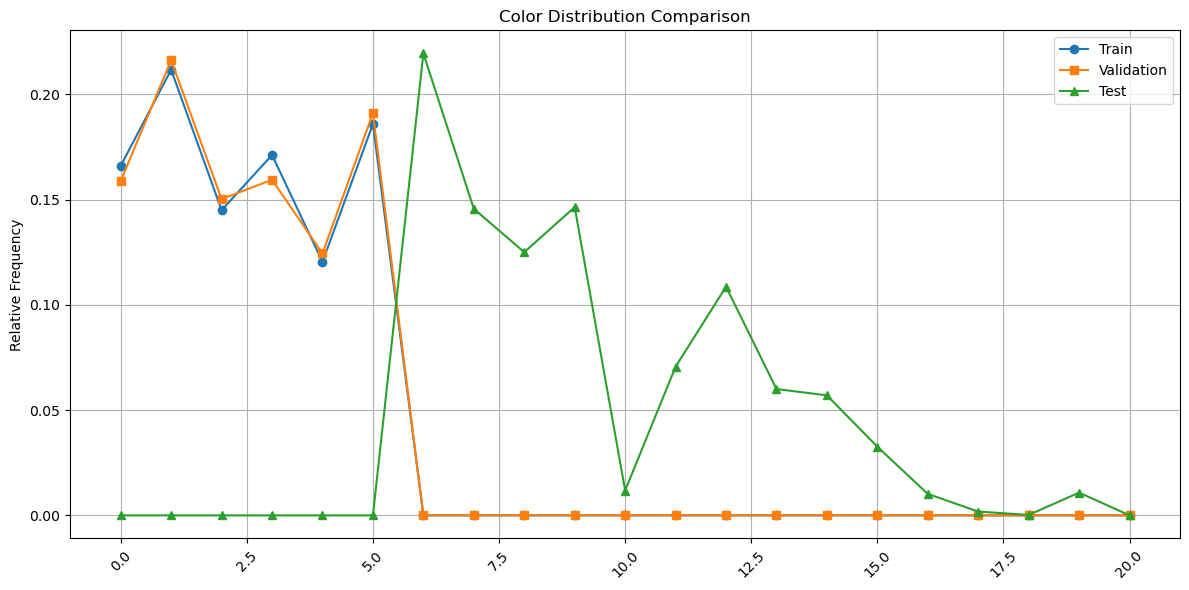

In [40]:
plot_compare_distribution(train_dist=train_multi_color_dist, val_dist=val_multi_color_dist, test_dist=test_multi_color_dist, feature=list(range(multi_color_lengths["Color"]+1)))

### Train, Val: Black - Silver - Grey. Test: Everything else

In [ ]:
train_b_s_g_df, val_b_s_g_df, test_b_s_g_df = create_shifted_splits(df=full_data_df, 
                                                                     split=[{"Color": "Black"},
                                                                            {"Color": "Silver"},
                                                                            {"Color": "Grey"}],
                                                                     split_cond="or",
                                                                     ratio=ratio,
                                                                     mode=1)

cat_plus_gen_cols = categorical_columns + ["Genmodel_ID"]
train_b_s_g_df, val_b_s_g_df, test_b_s_g_df, cat_mapping = categorize(train_df=train_b_s_g_df,
                                                                       val_df=val_b_s_g_df,
                                                                       test_df=test_b_s_g_df,
                                                                       categorical_columns=cat_plus_gen_cols)

train_b_s_g_df, val_b_s_g_df, test_b_s_g_df, mean_b_s_g, std_b_s_g = normalize(train_df=train_b_s_g_df,
                                                         val_df=val_b_s_g_df,
                                                         test_df=test_b_s_g_df,
                                                         continuous_columns=continuous_columns)

train_b_s_g_df = reorder_df(df=train_b_s_g_df, new_order=reorder_columns)
val_b_s_g_df = reorder_df(df=val_b_s_g_df, new_order=reorder_columns)
test_b_s_g_df = reorder_df(df=test_b_s_g_df, new_order=reorder_columns)

display(train_b_s_g_df)
display(val_b_s_g_df)
display(test_b_s_g_df)

Shape of train df:	(29000, 21)
Shape of val df:	(5000, 21)
Shape of test df:	(5000, 21)
Total Size: 39000
Ratio -> Train: 0.74 | Val: 0.13 | Test: 0.13


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
13,0,0,0,0,0.016201,1.075294,0.956918,-1.190697,7.104967,0.076093,...,7.202082,5.356594,1.643351,1.558322,2.255956,1.721035,10_3$$72,0,225,Bentley$$Bentayga$$2016$$Black$$10_3$$72$$imag...
21,1,0,0,0,0.016201,1.075294,0.956918,-0.759821,6.101551,0.076093,...,7.202082,5.356594,2.077700,1.323986,2.255956,1.874955,10_3$$111,0,315,Bentley$$Bentayga$$2016$$Silver$$10_3$$111$$im...
33,0,0,0,0,-2.393116,2.041701,1.419236,-1.364253,13.801483,0.076093,...,7.202082,5.356594,1.846780,1.527077,2.379595,1.921375,10_3$$20,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$20$$imag...
34,1,0,0,1,-2.393116,3.008108,1.419236,-1.363285,11.982601,0.076093,...,7.202082,2.713303,2.017221,1.550511,2.008680,1.860296,10_3$$21,0,135,Bentley$$Bentayga$$2018$$Silver$$10_3$$21$$ima...
36,0,0,0,0,0.016201,-1.340723,1.419236,-1.304682,8.939006,0.076093,...,7.202082,2.713303,1.769807,1.855148,2.275478,1.882285,10_3$$23,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$23$$imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176394,1,6,1,0,0.016201,-2.307130,-1.354671,1.056383,-0.601028,0.076093,...,-0.354942,-0.194317,0.114883,-0.816287,-1.062755,0.176946,96_9$$385,285,45,Volvo$$V50$$2006$$Silver$$96_9$$385$$image_0.jpg
176398,1,6,1,0,0.016201,-1.823927,-1.354671,0.679823,-0.504628,0.076093,...,-0.354942,-0.194317,0.015917,-0.363237,-0.704855,0.372400,96_9$$450,285,315,Volvo$$V50$$2006$$Silver$$96_9$$450$$image_1.jpg
176399,1,6,1,1,0.016201,0.592091,-1.354671,-0.348148,-0.474010,0.076093,...,-0.354942,0.070012,-0.061056,-0.675685,-1.088784,0.357741,96_9$$454,285,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg
176405,2,6,1,1,0.016201,0.108887,-1.816989,0.491762,-0.534336,0.076093,...,-0.267736,0.070012,-0.110539,-0.566328,-0.490115,0.321094,96_9$$217,285,315,Volvo$$V50$$2004$$Grey$$96_9$$217$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
0,2,0,0,0,0.016201,-1.340723,0.956918,-1.058623,7.134675,0.076093,...,7.202082,5.356594,1.775305,1.628623,1.885041,1.777228,10_3$$1,0,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...
23,2,0,0,0,0.016201,0.592091,0.956918,-0.824744,6.528988,0.076093,...,7.202082,5.356594,2.066704,1.534888,2.392609,1.757682,10_3$$118,0,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$118$$imag...
43,2,0,0,0,0.016201,-0.857520,1.419236,-1.341006,9.530142,0.076093,...,7.202082,2.713303,1.670842,1.675490,1.930592,1.777228,10_3$$32,0,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$32$$image...
70,1,0,0,0,0.016201,-1.340723,1.419236,-1.364617,9.712031,0.076093,...,7.202082,5.356594,1.637853,1.261496,2.457682,1.872512,10_3$$115,0,225,Bentley$$Bentayga$$2018$$Silver$$10_3$$115$$im...
84,2,0,0,0,-2.393116,2.041701,1.188077,-1.167934,7.981062,0.076093,...,7.202082,5.356594,2.099692,1.292741,2.464189,1.931148,10_3$$35,0,225,Bentley$$Bentayga$$2017$$Grey$$10_3$$35$$image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176258,0,6,1,1,0.016201,1.075294,0.032283,2.020182,-0.549493,0.076093,...,-0.128584,-0.458646,-0.017071,-0.464783,-1.127828,0.374844,96_9$$55,285,0,Volvo$$V50$$2012$$Black$$96_9$$55$$image_0.jpg
176267,0,6,1,1,0.016201,1.075294,0.032283,0.979473,-0.413077,0.076093,...,-0.128584,-0.458646,0.015917,-0.597573,-0.711362,0.223367,96_9$$139,285,0,Volvo$$V50$$2012$$Black$$96_9$$139$$image_1.jpg
176324,1,6,1,1,0.016201,-1.340723,-0.430035,0.972087,-0.492502,0.076093,...,-0.248847,-0.458646,-0.132531,-0.277314,-0.841508,0.220923,96_9$$392,285,135,Volvo$$V50$$2010$$Silver$$96_9$$392$$image_0.jpg
176372,0,6,1,1,0.016201,0.108887,-1.354671,1.403883,-0.607395,0.076093,...,-0.354942,0.070012,0.037910,-0.394482,-1.004190,0.172060,96_9$$49,285,45,Volvo$$V50$$2006$$Black$$96_9$$49$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
2,3,0,0,0,0.016201,0.108887,0.956918,-0.965028,7.007657,0.076093,...,7.202082,5.356594,1.736819,1.386475,2.353565,1.794330,10_3$$10,0,225,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...
63,4,0,0,0,-2.393116,1.558498,1.419236,-1.362800,13.195189,0.076093,...,7.202082,5.356594,1.857776,1.808281,1.943607,1.777228,10_3$$97,0,270,Bentley$$Bentayga$$2018$$White$$10_3$$97$$imag...
106,3,0,0,1,0.016201,0.108887,1.188077,-1.100032,7.435397,0.076093,...,7.202082,2.713303,1.758811,1.816092,2.464189,1.911603,10_3$$117,0,90,Bentley$$Bentayga$$2017$$Blue$$10_3$$117$$imag...
113,3,1,0,0,0.016201,1.075294,1.419236,-1.328898,12.591623,-1.129089,...,7.485423,5.356594,0.989079,-1.159981,1.806954,0.997854,10_5$$264,1,45,Bentley$$Continental$$2018$$Blue$$10_5$$264$$i...
234,5,2,0,0,0.016201,0.592091,0.494600,-0.798687,4.707075,-1.129089,...,6.836886,5.356594,0.246837,-0.925644,1.982651,0.997854,10_5$$28,1,90,Bentley$$Continental$$2014$$Red$$10_5$$28$$ima...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176159,3,6,1,1,-2.393116,3.008108,-0.892353,2.477090,-0.534336,0.076093,...,-0.354942,0.598670,-0.231497,-0.730364,-0.913088,0.382173,96_9$$52,285,270,Volvo$$V50$$2008$$Blue$$96_9$$52$$image_0.jpg
176194,3,6,1,1,0.016201,1.075294,-0.892353,1.201679,-0.546765,0.076093,...,-0.354942,-0.458646,0.136875,-0.870966,-1.140843,0.313764,96_9$$210,285,135,Volvo$$V50$$2008$$Blue$$96_9$$210$$image_10.jpg
176234,3,6,1,1,0.016201,0.592091,-0.892353,1.177463,-0.510388,0.076093,...,-0.354942,0.070012,-0.182014,-0.745986,-0.717870,0.250242,96_9$$413,285,315,Volvo$$V50$$2008$$Blue$$96_9$$413$$image_0.jpg
176273,4,6,1,1,0.016201,-0.374316,0.032283,0.204632,-0.322740,0.076093,...,-0.128584,-0.458646,-0.149025,-0.839721,-0.874044,0.252685,96_9$$181,285,270,Volvo$$V50$$2012$$White$$96_9$$181$$image_1.jpg


In [42]:
b_s_g_lengths = get_lengths(df_list=[train_b_s_g_df, val_b_s_g_df, test_b_s_g_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)

In [43]:
k = 0.1
low_train_b_s_g_df, high_train_b_s_g_df = create_splitted_train(train_df=train_b_s_g_df, low_data_split=k, nclasses=train_b_s_g_df["Genmodel_ID"].nunique())
display(low_train_b_s_g_df)
display(high_train_b_s_g_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
13,0,0,0,0,0.016201,1.075294,0.956918,-1.190697,7.104967,0.076093,...,7.202082,5.356594,1.643351,1.558322,2.255956,1.721035,10_3$$72,0,225,Bentley$$Bentayga$$2016$$Black$$10_3$$72$$imag...
56,2,0,0,1,0.016201,-1.823927,1.419236,-1.195710,9.257310,0.076093,...,7.202082,2.713303,1.879769,1.503644,2.457682,1.808989,10_3$$78,0,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$78$$image...
82,2,0,0,0,0.016201,-1.823927,1.188077,-1.239662,8.223579,-1.129089,...,7.202082,5.356594,2.050210,1.238062,2.132318,1.933591,10_3$$17,0,0,Bentley$$Bentayga$$2017$$Grey$$10_3$$17$$image...
109,0,1,0,0,-2.393116,1.075294,1.419236,-1.362800,10.163720,-1.129089,...,7.485423,2.713303,0.681186,-0.972512,2.477204,1.044274,10_5$$20,1,90,Bentley$$Continental$$2018$$Black$$10_5$$20$$i...
110,2,1,0,0,0.016201,1.075294,1.419236,-1.341006,10.771529,-1.129089,...,7.485423,5.356594,1.143025,-1.152170,1.748389,1.134672,10_5$$40,1,90,Bentley$$Continental$$2018$$Grey$$10_5$$40$$im...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176221,1,6,1,1,0.016201,0.592091,-0.892353,1.078008,-0.537368,0.076093,...,-0.354942,0.070012,-0.357953,-0.949078,-0.750406,0.303991,96_9$$336,285,90,Volvo$$V50$$2008$$Silver$$96_9$$336$$image_0.jpg
176352,1,6,0,0,0.016201,1.075294,-1.585830,0.402550,-0.516450,0.076093,...,-0.255143,0.598670,-0.105041,-0.738175,-1.069263,0.357741,96_9$$338,285,315,Volvo$$V50$$2005$$Silver$$96_9$$338$$image_0.jpg
176360,2,6,1,0,0.016201,0.592091,-1.585830,1.250111,-0.613154,0.076093,...,-0.255143,-0.194317,-0.253489,-0.488216,-0.821986,0.218480,96_9$$393,285,45,Volvo$$V50$$2005$$Grey$$96_9$$393$$image_0.jpg
176369,1,6,1,0,0.016201,-0.374316,-1.585830,2.557778,-0.668024,0.076093,...,-0.255143,-0.194317,0.103887,-0.449160,-0.581217,0.365071,96_9$$502,285,315,Volvo$$V50$$2005$$Silver$$96_9$$502$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
21,1,0,0,0,0.016201,1.075294,0.956918,-0.759821,6.101551,0.076093,...,7.202082,5.356594,2.077700,1.323986,2.255956,1.874955,10_3$$111,0,315,Bentley$$Bentayga$$2016$$Silver$$10_3$$111$$im...
33,0,0,0,0,-2.393116,2.041701,1.419236,-1.364253,13.801483,0.076093,...,7.202082,5.356594,1.846780,1.527077,2.379595,1.921375,10_3$$20,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$20$$imag...
34,1,0,0,1,-2.393116,3.008108,1.419236,-1.363285,11.982601,0.076093,...,7.202082,2.713303,2.017221,1.550511,2.008680,1.860296,10_3$$21,0,135,Bentley$$Bentayga$$2018$$Silver$$10_3$$21$$ima...
36,0,0,0,0,0.016201,-1.340723,1.419236,-1.304682,8.939006,0.076093,...,7.202082,2.713303,1.769807,1.855148,2.275478,1.882285,10_3$$23,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$23$$imag...
40,0,0,0,1,0.016201,-0.857520,1.419236,-1.328898,9.557426,0.076093,...,7.202082,2.713303,1.879769,1.777036,2.249449,1.879841,10_3$$28,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$28$$imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176394,1,6,1,0,0.016201,-2.307130,-1.354671,1.056383,-0.601028,0.076093,...,-0.354942,-0.194317,0.114883,-0.816287,-1.062755,0.176946,96_9$$385,285,45,Volvo$$V50$$2006$$Silver$$96_9$$385$$image_0.jpg
176398,1,6,1,0,0.016201,-1.823927,-1.354671,0.679823,-0.504628,0.076093,...,-0.354942,-0.194317,0.015917,-0.363237,-0.704855,0.372400,96_9$$450,285,315,Volvo$$V50$$2006$$Silver$$96_9$$450$$image_1.jpg
176399,1,6,1,1,0.016201,0.592091,-1.354671,-0.348148,-0.474010,0.076093,...,-0.354942,0.070012,-0.061056,-0.675685,-1.088784,0.357741,96_9$$454,285,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg
176405,2,6,1,1,0.016201,0.108887,-1.816989,0.491762,-0.534336,0.076093,...,-0.267736,0.070012,-0.110539,-0.566328,-0.490115,0.321094,96_9$$217,285,315,Volvo$$V50$$2004$$Grey$$96_9$$217$$image_0.jpg


In [44]:
b_s_g_dir = os.path.join(SHIFTED_DIR, "black-silver-grey")

In [45]:
save_dataset(df=train_b_s_g_df, save_directory=b_s_g_dir, split="train", k="", keep_cols=reorder_columns)
save_dataset(df=low_train_b_s_g_df, save_directory=b_s_g_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_b_s_g_df, save_directory=b_s_g_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)
save_dataset(df=val_b_s_g_df, save_directory=b_s_g_dir, split="val", k="", keep_cols=reorder_columns)
save_dataset(df=test_b_s_g_df, save_directory=b_s_g_dir, split="test", k="", keep_cols=reorder_columns)

In [46]:
k = 0.01
low_train_b_s_g_df, high_train_b_s_g_df = create_splitted_train(train_df=train_b_s_g_df, low_data_split=k, nclasses=train_b_s_g_df["Genmodel_ID"].nunique())
display(low_train_b_s_g_df)
display(high_train_b_s_g_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
13,0,0,0,0,0.016201,1.075294,0.956918,-1.190697,7.104967,0.076093,...,7.202082,5.356594,1.643351,1.558322,2.255956,1.721035,10_3$$72,0,225,Bentley$$Bentayga$$2016$$Black$$10_3$$72$$imag...
109,0,1,0,0,-2.393116,1.075294,1.419236,-1.362800,10.163720,-1.129089,...,7.485423,2.713303,0.681186,-0.972512,2.477204,1.044274,10_5$$20,1,90,Bentley$$Continental$$2018$$Black$$10_5$$20$$i...
821,0,4,1,0,0.016201,-0.857520,-0.198876,0.063525,-0.625280,0.076093,...,-0.914699,-1.251633,-1.474065,-0.355426,-2.266602,-1.894869,16_14$$27,2,0,Chevrolet$$Spark$$2011$$Black$$16_14$$27$$imag...
1003,2,5,0,0,0.016201,-2.307130,0.725759,-0.929672,-0.286665,0.076093,...,-0.537540,-0.458646,-0.528394,0.620976,-0.789450,-0.866291,18_10$$78,3,90,Citroen$$C3 Picasso$$2015$$Grey$$18_10$$78$$im...
1453,0,4,1,1,0.016201,-0.857520,0.263441,-0.171153,-0.385855,0.076093,...,-0.478668,-0.458646,-0.363451,-0.691308,-0.522651,-0.177315,18_12$$2,4,225,Citroen$$C4$$2013$$Black$$18_12$$2$$image_1.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174825,2,3,0,1,0.016201,0.108887,-0.198876,-0.269930,-0.188445,0.076093,...,0.023161,0.598670,0.879117,-0.496028,-0.340448,0.489673,96_4$$70,281,225,Volvo$$S60$$2011$$Grey$$96_4$$70$$image_0.jpg
175240,1,3,1,1,0.016201,0.592091,-0.892353,0.233037,-0.461884,0.076093,...,0.114145,0.070012,0.703178,-0.089844,1.403503,1.046718,96_5$$37,282,0,Volvo$$S80$$2008$$Silver$$96_5$$37$$image_13.jpg
175345,1,3,0,1,0.016201,-0.374316,1.419236,-1.364011,1.102657,0.076093,...,0.808016,0.070012,1.769807,-0.956889,0.895935,1.415638,96_6$$19,283,225,Volvo$$S90$$2018$$Silver$$96_6$$19$$image_0.jpg
175507,1,4,1,0,0.016201,-0.857520,0.263441,-0.614524,-0.141761,0.076093,...,-0.155974,-0.458646,0.032411,-0.628818,1.136705,-0.104019,96_7$$335,284,0,Volvo$$V40$$2013$$Silver$$96_7$$335$$image_11.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
21,1,0,0,0,0.016201,1.075294,0.956918,-0.759821,6.101551,0.076093,...,7.202082,5.356594,2.077700,1.323986,2.255956,1.874955,10_3$$111,0,315,Bentley$$Bentayga$$2016$$Silver$$10_3$$111$$im...
33,0,0,0,0,-2.393116,2.041701,1.419236,-1.364253,13.801483,0.076093,...,7.202082,5.356594,1.846780,1.527077,2.379595,1.921375,10_3$$20,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$20$$imag...
34,1,0,0,1,-2.393116,3.008108,1.419236,-1.363285,11.982601,0.076093,...,7.202082,2.713303,2.017221,1.550511,2.008680,1.860296,10_3$$21,0,135,Bentley$$Bentayga$$2018$$Silver$$10_3$$21$$ima...
36,0,0,0,0,0.016201,-1.340723,1.419236,-1.304682,8.939006,0.076093,...,7.202082,2.713303,1.769807,1.855148,2.275478,1.882285,10_3$$23,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$23$$imag...
40,0,0,0,1,0.016201,-0.857520,1.419236,-1.328898,9.557426,0.076093,...,7.202082,2.713303,1.879769,1.777036,2.249449,1.879841,10_3$$28,0,90,Bentley$$Bentayga$$2018$$Black$$10_3$$28$$imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176394,1,6,1,0,0.016201,-2.307130,-1.354671,1.056383,-0.601028,0.076093,...,-0.354942,-0.194317,0.114883,-0.816287,-1.062755,0.176946,96_9$$385,285,45,Volvo$$V50$$2006$$Silver$$96_9$$385$$image_0.jpg
176398,1,6,1,0,0.016201,-1.823927,-1.354671,0.679823,-0.504628,0.076093,...,-0.354942,-0.194317,0.015917,-0.363237,-0.704855,0.372400,96_9$$450,285,315,Volvo$$V50$$2006$$Silver$$96_9$$450$$image_1.jpg
176399,1,6,1,1,0.016201,0.592091,-1.354671,-0.348148,-0.474010,0.076093,...,-0.354942,0.070012,-0.061056,-0.675685,-1.088784,0.357741,96_9$$454,285,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg
176405,2,6,1,1,0.016201,0.108887,-1.816989,0.491762,-0.534336,0.076093,...,-0.267736,0.070012,-0.110539,-0.566328,-0.490115,0.321094,96_9$$217,285,315,Volvo$$V50$$2004$$Grey$$96_9$$217$$image_0.jpg


In [47]:
save_dataset(df=low_train_b_s_g_df, save_directory=b_s_g_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_b_s_g_df, save_directory=b_s_g_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)

In [48]:
train_b_s_g_dist = create_dist_dfs(df=train_b_s_g_df,
                                  cols=["Color"],
                                  fill_values=list(range(b_s_g_lengths["Color"] + 1)))
val_b_s_g_dist = create_dist_dfs(df=val_b_s_g_df,
                                cols=["Color"],
                                fill_values=list(range(b_s_g_lengths["Color"] + 1)))
test_b_s_g_dist = create_dist_dfs(df=test_b_s_g_df,
                                 cols=["Color"],
                                 fill_values=list(range(b_s_g_lengths["Color"] + 1)))


In [99]:
train_test_kl_b_s_g = calc_JS(first_dist=train_b_s_g_dist, second_dist=test_b_s_g_dist)
train_test_kl_b_s_g

0.8325546111576978

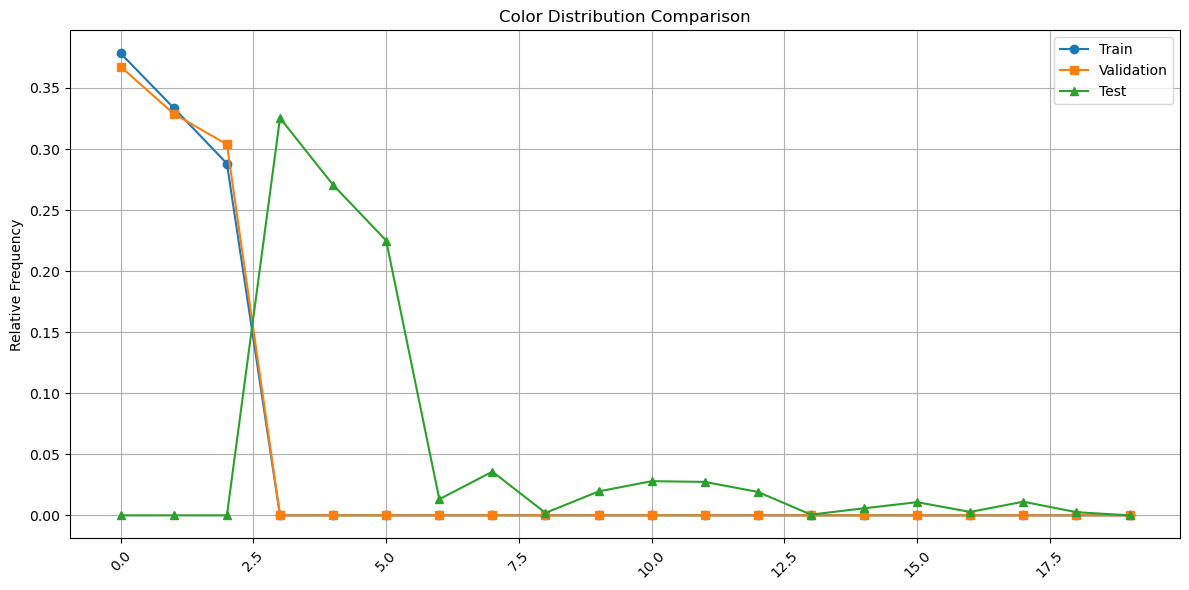

In [50]:
plot_compare_distribution(train_dist=train_b_s_g_dist, val_dist=val_b_s_g_dist, test_dist=test_b_s_g_dist, feature=list(range(b_s_g_lengths["Color"] + 1)))

### Train, Val: Only Black. Test: No Black

In [ ]:
train_black_df, val_black_df, test_black_df = create_shifted_splits(df=full_data_df, 
                                                                               split=[{"Color": "Black"}],
                                                                               split_cond="and",
                                                                               ratio=ratio,
                                                                               mode=1)

cat_plus_gen_cols = categorical_columns + ["Genmodel_ID"]
train_black_df, val_black_df, test_black_df, cat_mapping = categorize(train_df=train_black_df,
                                                                    val_df=val_black_df,
                                                                    test_df=test_black_df,
                                                                    categorical_columns=cat_plus_gen_cols)

train_black_df, val_black_df, test_black_df, mean_black, std_black = normalize(train_df=train_black_df,
                                                                    val_df=val_black_df,
                                                                    test_df=test_black_df,
                                                                    continuous_columns=continuous_columns)

train_black_df = reorder_df(df=train_black_df, new_order=reorder_columns)
val_black_df = reorder_df(df=val_black_df, new_order=reorder_columns)
test_black_df = reorder_df(df=test_black_df, new_order=reorder_columns)

display(train_black_df)
display(val_black_df)
display(test_black_df)

Too little data.
Shape of train df:	(29000, 21)
Shape of val df:	(5000, 21)
Shape of test df:	(5000, 21)
Total Size: 39000
Ratio -> Train: 0.74 | Val: 0.13 | Test: 0.13


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
7,0,0,0,0,0.002985,1.083799,-1.257101,0.737795,-0.497205,0.121972,...,0.223757,1.233045,0.558335,1.747353,0.018634,0.928916,40_4$$84,0,0,Jeep$$Grand Cherokee$$2007$$Black$$40_4$$84$$i...
20,0,1,1,1,0.002985,-0.369956,-0.047548,-0.552870,-0.497506,0.121972,...,-0.807619,-0.945795,-0.589178,-0.100215,0.497496,-0.856746,75_2$$962,1,45,Renault$$Clio$$2012$$Black$$75_2$$962$$image_0...
21,0,2,0,1,0.002985,-1.339125,1.403916,-0.922575,1.131241,0.121972,...,-0.131633,0.022578,-0.112358,-1.211822,0.452802,0.227655,7_3$$1609,2,90,Audi$$A3$$2018$$Black$$7_3$$1609$$image_2.jpg
27,0,0,1,0,0.002985,1.083799,-0.289459,0.251355,-0.196490,0.121972,...,-0.110838,0.264672,-0.248592,1.379372,1.193442,0.320537,34_3$$439,3,0,Honda$$CR-V$$2011$$Black$$34_3$$439$$image_0.jpg
31,0,0,1,0,0.002985,-0.854540,0.678184,-0.459452,-0.044473,0.121972,...,-0.153600,0.022578,-0.033761,1.632359,1.333908,0.241587,29_25$$395,4,90,Ford$$Kuga$$2015$$Black$$29_25$$395$$image_0.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33994,0,0,1,0,0.002985,0.599214,0.920095,-0.879887,-0.225445,0.121972,...,-0.490421,-0.582655,-0.845928,1.111053,1.046591,-0.285520,29_4$$430,165,0,Ford$$EcoSport$$2016$$Black$$29_4$$430$$image_...
33996,0,3,0,0,0.002985,-0.369956,0.436273,-0.542049,-0.045077,2.493527,...,-0.199876,-0.461609,1.066595,0.612747,-0.517691,0.457538,18_24$$1161,51,90,Citroen$$Grand C4 Picasso$$2014$$Black$$18_24$...
33997,0,1,1,1,0.002985,-0.854540,-0.289459,0.069316,-0.629616,-1.063806,...,-0.859753,-0.945795,-1.956763,-0.199876,-1.954276,-2.089758,28_18$$52,105,0,Fiat$$Panda$$2011$$Black$$28_18$$52$$image_4.jpg
33998,0,0,1,0,0.002985,0.599214,-0.289459,0.610347,-0.485441,0.121972,...,-0.423643,-0.582655,0.102474,0.428757,-1.060401,-0.027772,64_33$$1621,15,45,Nissan$$Qashqai$$2011$$Black$$64_33$$1621$$ima...


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
0,0,1,0,1,0.002985,1.083799,-0.047548,-0.255303,-0.527065,-1.063806,...,-0.848038,-1.187889,-1.851967,-0.376200,-0.370840,-2.270878,69_3$$768,33,135,Peugeot$$107$$2012$$Black$$69_3$$768$$image_0.jpg
1,0,0,0,0,0.002985,-1.339125,0.194363,0.310976,1.372597,0.121972,...,2.707624,1.233045,1.139952,2.337654,1.889388,1.442090,47_13$$283,48,90,Land Rover$$Range Rover$$2013$$Black$$47_13$$2...
2,0,1,1,1,0.002985,-1.823710,0.678184,-0.558605,-0.166026,0.121972,...,-0.278956,-0.461609,-0.384827,-0.038885,-0.351685,-0.248367,21_3$$436,26,225,Citroen$$DS4$$2015$$Black$$21_3$$436$$image_1.jpg
3,0,1,1,1,0.002985,0.114629,0.678184,-0.917795,-0.438389,-1.063806,...,-0.760171,-1.187889,-0.877367,0.252433,-1.705268,-1.913282,75_18$$92,80,225,Renault$$Twingo$$2015$$Black$$75_18$$92$$image...
4,0,3,1,0,0.002985,-0.369956,0.194363,-0.153481,-0.408408,0.121972,...,-0.284228,-0.582655,-0.007562,0.850401,1.008282,-0.060280,75_14$$924,173,225,Renault$$Scenic$$2013$$Black$$75_14$$924$$imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33968,0,1,1,1,0.002985,1.083799,-1.740922,0.336837,-0.620567,0.121972,...,-0.835619,0.022578,-0.730653,-0.636853,-0.115447,-1.035544,29_13$$382,19,45,Ford$$Fiesta$$2005$$Black$$29_13$$382$$image_0...
33973,0,0,0,0,0.002985,-0.369956,0.194363,-0.047511,1.517736,0.121972,...,2.707624,2.927699,1.113753,2.460314,2.291632,1.456023,47_13$$1900,48,225,Land Rover$$Range Rover$$2013$$Black$$47_13$$1...
33976,0,1,1,0,0.002985,1.083799,0.436273,-0.147097,-0.225445,0.121972,...,-0.333726,-0.461609,0.123433,-0.368534,-0.734775,-0.378402,95_15$$491,42,90,Volkswagen$$Golf$$2014$$Black$$95_15$$491$$ima...
33978,0,3,1,0,0.002985,1.083799,1.162005,-0.770743,-0.086760,0.121972,...,-0.200462,-0.582655,1.260467,0.934730,1.091285,-0.057958,29_2$$364,126,90,Ford$$C-Max$$2017$$Black$$29_2$$364$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
0,1,0,0,1,0.002985,-1.339125,0.920095,-0.766379,7.042989,0.121972,...,6.641697,4.864446,1.684890,1.586361,1.819155,1.699839,10_3$$1,240,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...
75,2,0,0,1,0.002985,1.083799,1.403916,-0.994532,10.828619,0.121972,...,6.641697,2.443512,1.684890,1.448369,2.093702,1.660364,10_3$$127,240,90,Bentley$$Bentayga$$2018$$Silver$$10_3$$127$$im...
98,1,0,0,1,0.002985,-2.308295,1.162005,-0.812168,8.850294,0.121972,...,6.641697,4.864446,1.705849,1.249046,1.972391,1.827552,10_3$$90,240,225,Bentley$$Bentayga$$2017$$Grey$$10_3$$90$$image...
108,1,5,0,1,0.002985,1.083799,1.403916,-0.946019,9.456550,-1.063806,...,6.905296,2.443512,0.699810,-0.912838,2.151166,0.898729,10_5$$1,190,135,Bentley$$Continental$$2018$$Grey$$10_5$$1$$ima...
163,3,5,0,1,0.002985,-0.369956,-1.015190,-0.266376,2.519295,-1.063806,...,5.745459,4.864446,0.464019,-1.503140,0.063328,1.054307,10_5$$61,190,0,Bentley$$Continental$$2008$$Blue$$10_5$$61$$im...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176234,3,4,1,0,0.002985,0.599214,-1.015190,0.898897,-0.563561,0.121972,...,-0.388789,0.022578,-0.180475,-0.744180,-0.734775,0.248553,96_9$$413,211,315,Volvo$$V50$$2008$$Blue$$96_9$$413$$image_0.jpg
176239,1,4,1,0,0.002985,0.114629,-1.015190,0.664450,-0.557830,0.121972,...,-0.388789,0.022578,-0.332429,-0.529525,-0.734775,0.202112,96_9$$444,211,0,Volvo$$V50$$2008$$Grey$$96_9$$444$$image_0.jpg
176339,2,4,1,1,0.002985,-0.369956,-1.740922,0.502140,-0.587449,0.121972,...,-0.295944,-0.219515,-0.274791,-0.567856,-0.919935,0.255519,96_9$$153,211,0,Volvo$$V50$$2005$$Silver$$96_9$$153$$image_0.jpg
176399,2,4,1,0,0.002985,0.599214,-1.499012,-0.237269,-0.527367,0.121972,...,-0.388789,0.022578,-0.065199,-0.675184,-1.098710,0.350724,96_9$$454,211,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg


In [52]:
#genmodel_mapping = cat_mapping["Genmodel_ID"]
#genmodel_to_car = unique_cars.set_index('Genmodel_ID')['Car Name'].to_dict()
#int_to_car = {v: genmodel_to_car[k] for k, v in genmodel_mapping.items() if k in genmodel_to_car}
#
#int_to_car

In [53]:
black_lengths = get_lengths(df_list=[train_black_df, val_black_df, test_black_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)

In [54]:
k = 0.1
low_train_black_df, high_train_black_df = create_splitted_train(train_df=train_black_df, low_data_split=k, nclasses=train_black_df["Genmodel_ID"].nunique())
display(low_train_black_df)
display(high_train_black_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
7,0,0,0,0,0.002985,1.083799,-1.257101,0.737795,-0.497205,0.121972,...,0.223757,1.233045,0.558335,1.747353,0.018634,0.928916,40_4$$84,0,0,Jeep$$Grand Cherokee$$2007$$Black$$40_4$$84$$i...
20,0,1,1,1,0.002985,-0.369956,-0.047548,-0.552870,-0.497506,0.121972,...,-0.807619,-0.945795,-0.589178,-0.100215,0.497496,-0.856746,75_2$$962,1,45,Renault$$Clio$$2012$$Black$$75_2$$962$$image_0...
21,0,2,0,1,0.002985,-1.339125,1.403916,-0.922575,1.131241,0.121972,...,-0.131633,0.022578,-0.112358,-1.211822,0.452802,0.227655,7_3$$1609,2,90,Audi$$A3$$2018$$Black$$7_3$$1609$$image_2.jpg
27,0,0,1,0,0.002985,1.083799,-0.289459,0.251355,-0.196490,0.121972,...,-0.110838,0.264672,-0.248592,1.379372,1.193442,0.320537,34_3$$439,3,0,Honda$$CR-V$$2011$$Black$$34_3$$439$$image_0.jpg
31,0,0,1,0,0.002985,-0.854540,0.678184,-0.459452,-0.044473,0.121972,...,-0.153600,0.022578,-0.033761,1.632359,1.333908,0.241587,29_25$$395,4,90,Ford$$Kuga$$2015$$Black$$29_25$$395$$image_0.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33930,0,1,1,1,0.002985,0.114629,1.403916,-0.960447,0.558163,0.121972,...,-0.131633,-1.187889,-0.211914,-0.629187,0.650732,-0.095111,7_3$$1841,2,225,Audi$$A3$$2018$$Black$$7_3$$1841$$image_1.jpg
33934,0,1,1,1,0.002985,-0.854540,1.403916,-0.924162,0.166057,0.121972,...,-0.553392,-1.187889,-0.631097,-0.115547,0.599653,-1.021612,29_13$$1564,19,225,Ford$$Fiesta$$2018$$Black$$29_13$$1564$$image_...
33957,0,4,0,0,0.002985,-0.854540,0.920095,-0.505530,0.769598,0.121972,...,1.407494,0.143625,1.150432,-1.073829,0.969973,1.330632,59_19$$11,152,180,Mercedes-Benz$$CLS$$2016$$Black$$59_19$$11$$im...
33959,0,1,1,1,0.002985,1.083799,-0.047548,-0.225835,-0.496903,0.121972,...,-0.678162,-0.703702,-0.950724,-0.491194,-0.951859,-1.005358,18_8$$356,107,225,Citroen$$C3$$2012$$Black$$18_8$$356$$image_1.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
85,0,1,1,0,0.002985,1.083799,-1.015190,1.434517,-0.623583,0.121972,...,-0.447952,-0.098469,-0.652056,-1.012499,-0.779469,-0.250689,7_3$$1413,2,180,Audi$$A3$$2008$$Black$$7_3$$1413$$image_0.jpg
86,0,1,0,0,0.002985,-0.369956,-0.047548,0.484106,-0.497024,0.121972,...,-0.452053,-0.461609,-0.248592,-0.337869,-0.753929,-0.199604,79_10$$524,5,135,SEAT$$Leon$$2012$$Black$$79_10$$524$$image_12.jpg
88,0,1,0,0,0.002985,-1.339125,-1.499012,0.574837,-0.617853,0.121972,...,-0.328630,0.022578,0.416861,0.106774,0.274027,-0.287842,59_11$$606,14,180,Mercedes-Benz$$B Class$$2006$$Black$$59_11$$60...
91,0,1,1,1,0.002985,0.599214,-0.531369,0.267694,-0.617853,0.121972,...,-0.824899,-0.945795,-1.406585,-0.268872,-1.494569,-1.574261,64_17$$979,12,0,Nissan$$Micra$$2010$$Black$$64_17$$979$$image_...
98,0,1,1,1,0.002985,0.114629,1.162005,-0.748272,-0.235700,0.121972,...,-0.848038,-1.187889,-0.536780,-0.422198,-1.309409,-1.016968,64_17$$1723,12,225,Nissan$$Micra$$2017$$Black$$64_17$$1723$$image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33994,0,0,1,0,0.002985,0.599214,0.920095,-0.879887,-0.225445,0.121972,...,-0.490421,-0.582655,-0.845928,1.111053,1.046591,-0.285520,29_4$$430,165,0,Ford$$EcoSport$$2016$$Black$$29_4$$430$$image_...
33996,0,3,0,0,0.002985,-0.369956,0.436273,-0.542049,-0.045077,2.493527,...,-0.199876,-0.461609,1.066595,0.612747,-0.517691,0.457538,18_24$$1161,51,90,Citroen$$Grand C4 Picasso$$2014$$Black$$18_24$...
33997,0,1,1,1,0.002985,-0.854540,-0.289459,0.069316,-0.629616,-1.063806,...,-0.859753,-0.945795,-1.956763,-0.199876,-1.954276,-2.089758,28_18$$52,105,0,Fiat$$Panda$$2011$$Black$$28_18$$52$$image_4.jpg
33998,0,0,1,0,0.002985,0.599214,-0.289459,0.610347,-0.485441,0.121972,...,-0.423643,-0.582655,0.102474,0.428757,-1.060401,-0.027772,64_33$$1621,15,45,Nissan$$Qashqai$$2011$$Black$$64_33$$1621$$ima...


In [55]:
black_dir = os.path.join(SHIFTED_DIR, "black")

In [56]:
save_lengths(lengths=black_lengths, file_name="tabular_lengths.pt", save_directory=black_dir)

Saved lengths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/tabular_lengths.pt


In [57]:
save_dataset(df=train_black_df, save_directory=black_dir, split="train", k="", keep_cols=reorder_columns)
save_dataset(df=low_train_black_df, save_directory=black_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_black_df, save_directory=black_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)
save_dataset(df=val_black_df, save_directory=black_dir, split="val", k="", keep_cols=reorder_columns)
save_dataset(df=test_black_df, save_directory=black_dir, split="test", k="", keep_cols=reorder_columns)

Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/labels_train.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/image_paths_train.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/dvm_features_train.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/labels_train_0.1.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/image_paths_train_0.1.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/dvm_features_train_0.1.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/labels_train_0.9.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/image_paths_train_0.9.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/dvm_features_train_0.9.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/labels_val.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/bl

In [58]:
k = 0.01
low_train_black_df, high_train_black_df = create_splitted_train(train_df=train_black_df, low_data_split=k, nclasses=train_black_df["Genmodel_ID"].nunique())
display(low_train_black_df)
display(high_train_black_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
7,0,0,0,0,0.002985,1.083799,-1.257101,0.737795,-0.497205,0.121972,...,0.223757,1.233045,0.558335,1.747353,0.018634,0.928916,40_4$$84,0,0,Jeep$$Grand Cherokee$$2007$$Black$$40_4$$84$$i...
20,0,1,1,1,0.002985,-0.369956,-0.047548,-0.552870,-0.497506,0.121972,...,-0.807619,-0.945795,-0.589178,-0.100215,0.497496,-0.856746,75_2$$962,1,45,Renault$$Clio$$2012$$Black$$75_2$$962$$image_0...
21,0,2,0,1,0.002985,-1.339125,1.403916,-0.922575,1.131241,0.121972,...,-0.131633,0.022578,-0.112358,-1.211822,0.452802,0.227655,7_3$$1609,2,90,Audi$$A3$$2018$$Black$$7_3$$1609$$image_2.jpg
27,0,0,1,0,0.002985,1.083799,-0.289459,0.251355,-0.196490,0.121972,...,-0.110838,0.264672,-0.248592,1.379372,1.193442,0.320537,34_3$$439,3,0,Honda$$CR-V$$2011$$Black$$34_3$$439$$image_0.jpg
31,0,0,1,0,0.002985,-0.854540,0.678184,-0.459452,-0.044473,0.121972,...,-0.153600,0.022578,-0.033761,1.632359,1.333908,0.241587,29_25$$395,4,90,Ford$$Kuga$$2015$$Black$$29_25$$395$$image_0.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14558,0,0,1,1,0.002985,0.599214,1.403916,-0.994532,0.223667,0.121972,...,-0.279835,0.022578,-0.227633,0.198769,-0.798623,-0.294808,57_6$$537,148,225,Mazda$$CX-3$$2018$$Black$$57_6$$537$$image_1.jpg
23071,0,0,0,0,-2.401459,2.052969,-0.531369,0.491320,0.286705,0.121972,...,2.327104,1.959325,1.103273,2.636638,1.640380,1.456023,47_13$$1206,48,270,Land Rover$$Range Rover$$2010$$Black$$47_13$$1...
25983,0,2,0,0,0.002985,0.599214,-0.773280,0.449823,-0.134959,0.121972,...,1.709168,1.233045,1.999277,-0.636853,-0.109062,1.651075,8_14$$105,178,0,BMW$$7 Series$$2009$$Black$$8_14$$105$$image_0...
27720,0,1,1,1,0.002985,-2.308295,-1.015190,-0.256854,-0.648437,0.121972,...,-0.722389,-0.945795,-0.678255,0.352094,0.574114,-0.847458,75_6$$57,284,270,Renault$$Grand Modus$$2008$$Black$$75_6$$57$$i...


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
85,0,1,1,0,0.002985,1.083799,-1.015190,1.434517,-0.623583,0.121972,...,-0.447952,-0.098469,-0.652056,-1.012499,-0.779469,-0.250689,7_3$$1413,2,180,Audi$$A3$$2008$$Black$$7_3$$1413$$image_0.jpg
86,0,1,0,0,0.002985,-0.369956,-0.047548,0.484106,-0.497024,0.121972,...,-0.452053,-0.461609,-0.248592,-0.337869,-0.753929,-0.199604,79_10$$524,5,135,SEAT$$Leon$$2012$$Black$$79_10$$524$$image_12.jpg
88,0,1,0,0,0.002985,-1.339125,-1.499012,0.574837,-0.617853,0.121972,...,-0.328630,0.022578,0.416861,0.106774,0.274027,-0.287842,59_11$$606,14,180,Mercedes-Benz$$B Class$$2006$$Black$$59_11$$60...
91,0,1,1,1,0.002985,0.599214,-0.531369,0.267694,-0.617853,0.121972,...,-0.824899,-0.945795,-1.406585,-0.268872,-1.494569,-1.574261,64_17$$979,12,0,Nissan$$Micra$$2010$$Black$$64_17$$979$$image_...
98,0,1,1,1,0.002985,0.114629,1.162005,-0.748272,-0.235700,0.121972,...,-0.848038,-1.187889,-0.536780,-0.422198,-1.309409,-1.016968,64_17$$1723,12,225,Nissan$$Micra$$2017$$Black$$64_17$$1723$$image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33994,0,0,1,0,0.002985,0.599214,0.920095,-0.879887,-0.225445,0.121972,...,-0.490421,-0.582655,-0.845928,1.111053,1.046591,-0.285520,29_4$$430,165,0,Ford$$EcoSport$$2016$$Black$$29_4$$430$$image_...
33996,0,3,0,0,0.002985,-0.369956,0.436273,-0.542049,-0.045077,2.493527,...,-0.199876,-0.461609,1.066595,0.612747,-0.517691,0.457538,18_24$$1161,51,90,Citroen$$Grand C4 Picasso$$2014$$Black$$18_24$...
33997,0,1,1,1,0.002985,-0.854540,-0.289459,0.069316,-0.629616,-1.063806,...,-0.859753,-0.945795,-1.956763,-0.199876,-1.954276,-2.089758,28_18$$52,105,0,Fiat$$Panda$$2011$$Black$$28_18$$52$$image_4.jpg
33998,0,0,1,0,0.002985,0.599214,-0.289459,0.610347,-0.485441,0.121972,...,-0.423643,-0.582655,0.102474,0.428757,-1.060401,-0.027772,64_33$$1621,15,45,Nissan$$Qashqai$$2011$$Black$$64_33$$1621$$ima...


In [59]:
save_dataset(df=low_train_black_df, save_directory=black_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_black_df, save_directory=black_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)

Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/labels_train_0.01.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/image_paths_train_0.01.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/dvm_features_train_0.01.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/labels_train_0.99.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/image_paths_train_0.99.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/black/dvm_features_train_0.99.csv


In [60]:
train_black_dist = create_dist_dfs(df=train_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(black_lengths["Color"]+1)))
val_black_dist = create_dist_dfs(df=val_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(black_lengths["Color"]+1)))
test_black_dist = create_dist_dfs(df=test_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(black_lengths["Color"]+1)))

In [100]:
train_test_kl_black = calc_JS(first_dist=train_black_dist, second_dist=test_black_dist)
train_test_kl_black

0.8325546111576977

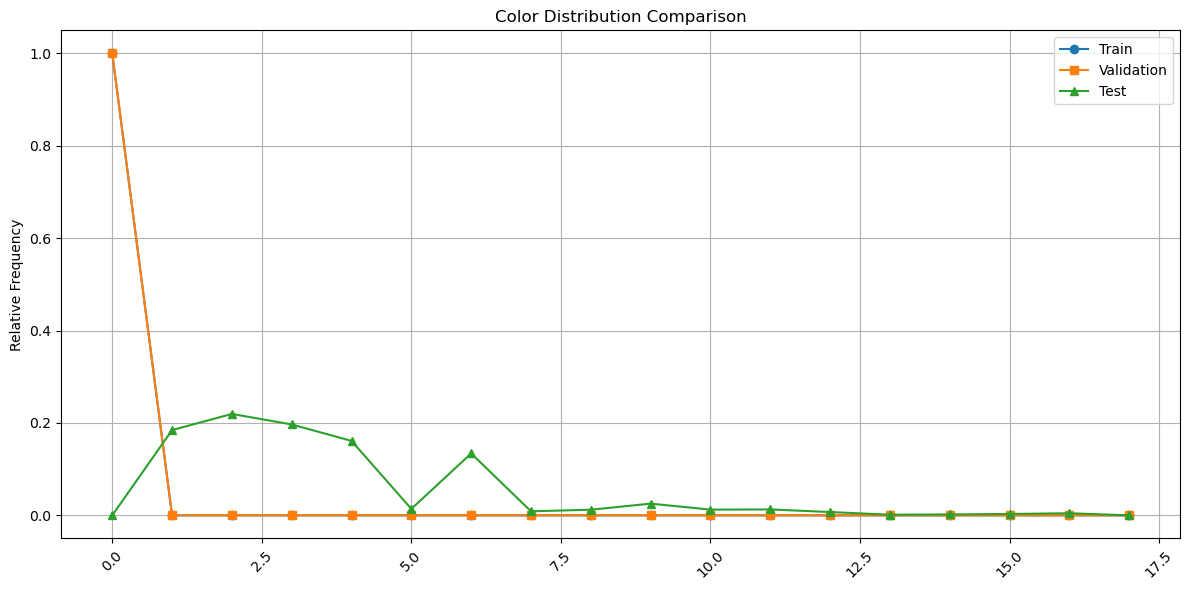

In [62]:
plot_compare_distribution(train_dist=train_black_dist, val_dist=val_black_dist, test_dist=test_black_dist, feature=list(range(black_lengths["Color"]+1)))

## Non-Image-based Features

### Train, Val: manual gearbox. Test: automatic gearbox

In [ ]:
train_gearbox_df, val_gearbox_df, test_gearbox_df = create_shifted_splits(df=full_data_df, 
                                                                           split=[{"Gearbox": "Manual"}],
                                                                           split_cond="and",
                                                                           ratio=ratio,
                                                                           mode=1)

cat_plus_gen_cols = categorical_columns + ["Genmodel_ID"]
train_gearbox_df, val_gearbox_df, test_gearbox_df, cat_mapping = categorize(train_df=train_gearbox_df,
                                                                            val_df=val_gearbox_df,
                                                                            test_df=test_gearbox_df,
                                                                            categorical_columns=cat_plus_gen_cols)

train_gearbox_df, val_gearbox_df, test_gearbox_df, mean_gearbox, std_gearbox = normalize(train_df=train_gearbox_df,
                                                               val_df=val_gearbox_df,
                                                               test_df=test_gearbox_df,
                                                               continuous_columns=continuous_columns)

train_gearbox_df = reorder_df(df=train_gearbox_df, new_order=reorder_columns)
val_gearbox_df = reorder_df(df=val_gearbox_df, new_order=reorder_columns)
test_gearbox_df = reorder_df(df=test_gearbox_df, new_order=reorder_columns)

display(train_gearbox_df)
display(val_gearbox_df)
display(test_gearbox_df)

Shape of train df:	(29000, 21)
Shape of val df:	(5000, 21)
Shape of test df:	(5000, 21)
Total Size: 39000
Ratio -> Train: 0.74 | Val: 0.13 | Test: 0.13


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
824,0,0,0,0,0.008627,1.106184,-0.235660,-0.077998,-0.750423,0.185664,...,-1.248758,-0.947899,-1.790503,0.255704,-1.510713,-1.621435,16_14$$33,0,45,Chevrolet$$Spark$$2011$$Black$$16_14$$33$$imag...
825,1,0,0,0,0.008627,-0.396854,-0.235660,0.575304,-0.801351,0.185664,...,-1.248758,-0.947899,-1.250089,0.516657,-2.090100,-1.457692,16_14$$40,0,225,Chevrolet$$Spark$$2011$$Silver$$16_14$$40$$ima...
833,2,0,0,0,0.008627,0.104159,-0.235660,0.433623,-0.903686,0.185664,...,-1.248758,-0.947899,-1.201590,0.125227,-1.841791,-1.599602,16_14$$63,0,135,Chevrolet$$Spark$$2011$$Blue$$16_14$$63$$image...
837,2,0,0,0,0.008627,-0.897866,-0.235660,0.567157,-0.934020,0.185664,...,-1.248758,-0.947899,-1.201590,-0.276240,-1.800407,-1.422215,16_14$$73,0,225,Chevrolet$$Spark$$2011$$Blue$$16_14$$73$$image...
840,3,0,0,0,0.008627,-0.396854,-0.235660,-0.110939,-0.698537,0.185664,...,-1.248758,-0.947899,-1.527224,0.245667,-1.724534,-1.498628,16_14$$78,0,0,Chevrolet$$Spark$$2011$$White$$16_14$$78$$imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176390,8,4,0,1,0.008627,0.104159,-1.433410,1.161712,-0.774530,0.185664,...,0.208102,1.007466,0.191014,-0.788110,-0.862351,0.755559,96_9$$355,253,90,Volvo$$V50$$2006$$Grey$$96_9$$355$$image_0.jpg
176391,8,4,0,1,0.008627,-0.396854,-1.433410,1.768917,-0.862178,0.185664,...,0.208102,1.007466,0.662143,-1.109283,-0.607145,0.709166,96_9$$360,253,90,Volvo$$V50$$2006$$Grey$$96_9$$360$$image_0.jpg
176395,4,4,0,1,0.008627,1.106184,-1.433410,2.882126,-0.983511,0.185664,...,0.208102,1.007466,0.475077,-0.707816,-0.814069,0.881095,96_9$$395,253,0,Volvo$$V50$$2006$$Green$$96_9$$395$$image_0.jpg
176410,1,4,0,1,0.008627,-0.396854,-1.912511,2.401422,-0.989897,0.185664,...,0.435071,1.007466,0.239512,-0.707816,-0.724402,0.900198,96_9$$374,253,0,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
817,1,0,0,0,0.008627,0.605171,-0.235660,-1.078115,-0.854355,0.185664,...,-1.248758,-0.947899,-1.485654,0.125227,-1.938356,-1.602331,16_14$$1,0,45,Chevrolet$$Spark$$2011$$Silver$$16_14$$1$$imag...
847,2,0,0,0,0.008627,0.605171,-0.235660,-0.781344,-0.582950,0.185664,...,-1.248758,-0.947899,-1.360943,-0.155800,-1.814202,-1.534105,16_14$$107,0,315,Chevrolet$$Spark$$2011$$Blue$$16_14$$107$$imag...
869,1,0,0,0,0.008627,-1.899892,-0.235660,-0.205334,-0.822265,0.185664,...,-1.248758,-1.436741,-1.790503,0.014824,-1.800407,-1.482254,16_14$$168,0,0,Chevrolet$$Spark$$2011$$Silver$$16_14$$168$$im...
901,1,0,0,0,-2.597489,1.106184,0.243441,-0.309292,-0.702528,0.185664,...,-1.178291,-1.436741,-1.645007,-0.045396,-1.896971,-1.741512,16_14$$83,0,0,Chevrolet$$Spark$$2013$$Silver$$16_14$$83$$ima...
906,3,0,0,0,0.008627,0.104159,0.243441,0.176067,-0.743238,0.185664,...,-1.178291,-1.436741,-1.187734,-0.446863,-1.986638,-1.542292,16_14$$96,0,0,Chevrolet$$Spark$$2013$$White$$16_14$$96$$imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176297,1,4,0,1,0.008627,-0.396854,0.003891,0.478607,-0.185422,0.185664,...,0.797238,0.029783,0.419650,-0.647596,-0.655427,0.842889,96_9$$436,253,0,Volvo$$V50$$2012$$Silver$$96_9$$436$$image_0.jpg
176330,0,4,0,1,0.008627,0.605171,-0.475210,1.085811,-0.423939,0.185664,...,0.484234,1.007466,0.620573,-0.788110,-0.482991,0.859263,96_9$$515,253,0,Volvo$$V50$$2010$$Black$$96_9$$515$$image_1.jpg
176344,1,4,0,1,0.008627,-0.897866,-1.672961,1.844818,-0.791133,0.185664,...,0.467846,1.007466,0.197942,-0.336460,-0.510580,0.766475,96_9$$250,253,0,Volvo$$V50$$2005$$Silver$$96_9$$250$$image_0.jpg
176379,8,4,0,1,0.008627,-1.398879,-1.433410,1.221193,-0.502966,0.185664,...,0.208102,1.007466,0.606716,-1.139393,-0.938223,0.853805,96_9$$160,253,135,Volvo$$V50$$2006$$Grey$$96_9$$160$$image_1.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
0,8,5,1,0,0.008627,-1.398879,0.962091,-1.047982,19.531476,0.185664,...,19.876537,10.784291,2.754514,2.273074,2.255304,2.502145,10_3$$1,254,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...
16,8,5,1,0,0.008627,1.106184,0.962091,-0.482801,18.413928,0.185664,...,19.876537,10.784291,2.685230,2.132560,2.620869,2.605849,10_3$$84,254,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$84$$image...
39,2,5,1,0,0.008627,1.106184,1.441192,-1.243224,14.344457,0.185664,...,19.876537,5.895878,2.789156,2.433660,2.379458,2.439377,10_3$$27,254,225,Bentley$$Bentayga$$2018$$Blue$$10_3$$27$$image...
48,0,5,1,1,-2.597489,1.106184,1.441192,-1.365778,32.297067,0.185664,...,19.876537,5.895878,2.754514,2.192780,2.551895,2.534894,10_3$$44,254,225,Bentley$$Bentayga$$2018$$Black$$10_3$$44$$imag...
54,0,5,1,1,0.008627,-1.899892,1.441192,-1.355658,27.513164,0.185664,...,19.876537,5.895878,2.643660,2.353367,2.682946,2.540352,10_3$$64,254,135,Bentley$$Bentayga$$2018$$Black$$10_3$$64$$imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176094,0,4,1,1,0.008627,-2.400904,-0.235660,0.073803,0.003922,0.185664,...,0.508815,1.007466,0.246441,-0.346496,-0.414016,0.845618,96_9$$83,253,0,Volvo$$V50$$2011$$Black$$96_9$$83$$image_1.jpg
176124,8,4,1,1,0.008627,1.106184,-0.235660,-0.730111,0.293686,0.185664,...,0.508815,1.007466,0.565146,-0.818220,-0.641632,0.971154,96_9$$333,253,0,Volvo$$V50$$2011$$Grey$$96_9$$333$$image_22.jpg
176167,0,4,1,1,0.008627,0.605171,-0.954310,1.667716,-0.663414,0.185664,...,0.208102,1.007466,0.405793,-1.018953,-0.814069,0.941134,96_9$$79,253,315,Volvo$$V50$$2008$$Black$$96_9$$79$$image_0.jpg
176325,0,4,1,1,0.008627,-0.396854,-0.475210,0.542034,-0.423939,0.185664,...,0.484234,1.007466,0.516648,-0.747963,-0.896839,0.793766,96_9$$396,253,45,Volvo$$V50$$2010$$Black$$96_9$$396$$image_10.jpg


In [64]:
gearbox_lengths = get_lengths(df_list=[train_gearbox_df, val_gearbox_df, test_gearbox_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)

In [65]:
k = 0.1
low_train_gearbox_df, high_train_gearbox_df = create_splitted_train(train_df=train_gearbox_df, low_data_split=k, nclasses=train_gearbox_df["Genmodel_ID"].nunique())
display(low_train_gearbox_df)
display(high_train_gearbox_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
824,0,0,0,0,0.008627,1.106184,-0.235660,-0.077998,-0.750423,0.185664,...,-1.248758,-0.947899,-1.790503,0.255704,-1.510713,-1.621435,16_14$$33,0,45,Chevrolet$$Spark$$2011$$Black$$16_14$$33$$imag...
876,2,0,0,0,0.008627,1.106184,-0.235660,0.402706,-0.855792,0.185664,...,-1.248758,-0.947899,-1.381728,0.085080,-1.503816,-1.632351,16_14$$184,0,0,Chevrolet$$Spark$$2011$$Blue$$16_14$$184$$imag...
929,4,0,0,0,0.008627,-0.897866,0.003891,-0.103298,-0.696301,0.185664,...,-1.178291,-0.947899,-1.444084,0.496584,-1.545200,-1.654183,16_14$$4,0,0,Chevrolet$$Spark$$2012$$Green$$16_14$$4$$image...
937,1,0,0,0,0.008627,-0.396854,0.003891,-0.280400,-0.664212,0.185664,...,-1.178291,-0.947899,-1.388657,-0.005250,-1.917663,-1.411299,16_14$$65,0,135,Chevrolet$$Spark$$2012$$Silver$$16_14$$65$$ima...
957,1,0,0,0,0.008627,0.605171,-0.475210,-0.529607,-0.782353,0.185664,...,-1.248758,-0.947899,-1.693505,0.406254,-1.717637,-1.599602,16_14$$10,0,225,Chevrolet$$Spark$$2010$$Silver$$16_14$$10$$ima...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176152,1,4,0,1,0.008627,1.106184,-0.954310,2.730325,-0.903048,0.185664,...,0.208102,1.007466,0.170229,-1.079173,-0.889941,0.938405,96_9$$22,253,90,Volvo$$V50$$2008$$Silver$$96_9$$22$$image_1.jpg
176216,0,4,0,1,0.008627,1.106184,-0.954310,1.596218,-0.743238,0.185664,...,0.208102,1.007466,0.294939,-0.747963,-0.765787,0.739185,96_9$$322,253,0,Volvo$$V50$$2008$$Black$$96_9$$322$$image_0.jpg
176223,2,4,0,1,0.008627,1.106184,-0.954310,3.919434,-0.998678,0.185664,...,0.208102,0.029783,0.350366,-0.868403,-0.282964,0.769205,96_9$$342,253,0,Volvo$$V50$$2008$$Blue$$96_9$$342$$image_0.jpg
176260,0,4,0,1,0.008627,1.106184,0.003891,0.832809,-0.263491,0.185664,...,0.797238,0.029783,0.405793,-0.607450,-0.517478,0.780121,96_9$$84,253,180,Volvo$$V50$$2012$$Black$$96_9$$84$$image_10.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
825,1,0,0,0,0.008627,-0.396854,-0.235660,0.575304,-0.801351,0.185664,...,-1.248758,-0.947899,-1.250089,0.516657,-2.090100,-1.457692,16_14$$40,0,225,Chevrolet$$Spark$$2011$$Silver$$16_14$$40$$ima...
833,2,0,0,0,0.008627,0.104159,-0.235660,0.433623,-0.903686,0.185664,...,-1.248758,-0.947899,-1.201590,0.125227,-1.841791,-1.599602,16_14$$63,0,135,Chevrolet$$Spark$$2011$$Blue$$16_14$$63$$image...
837,2,0,0,0,0.008627,-0.897866,-0.235660,0.567157,-0.934020,0.185664,...,-1.248758,-0.947899,-1.201590,-0.276240,-1.800407,-1.422215,16_14$$73,0,225,Chevrolet$$Spark$$2011$$Blue$$16_14$$73$$image...
840,3,0,0,0,0.008627,-0.396854,-0.235660,-0.110939,-0.698537,0.185664,...,-1.248758,-0.947899,-1.527224,0.245667,-1.724534,-1.498628,16_14$$78,0,0,Chevrolet$$Spark$$2011$$White$$16_14$$78$$imag...
843,2,0,0,0,0.008627,0.605171,-0.235660,0.246654,-0.699335,0.185664,...,-1.248758,-1.436741,-1.263946,-0.356533,-1.524508,-1.430402,16_14$$98,0,135,Chevrolet$$Spark$$2011$$Blue$$16_14$$98$$image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176390,8,4,0,1,0.008627,0.104159,-1.433410,1.161712,-0.774530,0.185664,...,0.208102,1.007466,0.191014,-0.788110,-0.862351,0.755559,96_9$$355,253,90,Volvo$$V50$$2006$$Grey$$96_9$$355$$image_0.jpg
176391,8,4,0,1,0.008627,-0.396854,-1.433410,1.768917,-0.862178,0.185664,...,0.208102,1.007466,0.662143,-1.109283,-0.607145,0.709166,96_9$$360,253,90,Volvo$$V50$$2006$$Grey$$96_9$$360$$image_0.jpg
176395,4,4,0,1,0.008627,1.106184,-1.433410,2.882126,-0.983511,0.185664,...,0.208102,1.007466,0.475077,-0.707816,-0.814069,0.881095,96_9$$395,253,0,Volvo$$V50$$2006$$Green$$96_9$$395$$image_0.jpg
176410,1,4,0,1,0.008627,-0.396854,-1.912511,2.401422,-0.989897,0.185664,...,0.435071,1.007466,0.239512,-0.707816,-0.724402,0.900198,96_9$$374,253,0,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg


In [66]:
gearbox_dir = os.path.join(SHIFTED_DIR, "gearbox")

In [67]:
save_lengths(lengths=gearbox_lengths, file_name="tabular_lengths.pt", save_directory=gearbox_dir)

Saved lengths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/tabular_lengths.pt


In [68]:
save_dataset(df=train_gearbox_df, save_directory=gearbox_dir, split="train", k="", keep_cols=reorder_columns)
save_dataset(df=low_train_gearbox_df, save_directory=gearbox_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_gearbox_df, save_directory=gearbox_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)
save_dataset(df=val_gearbox_df, save_directory=gearbox_dir, split="val", k="", keep_cols=reorder_columns)
save_dataset(df=test_gearbox_df, save_directory=gearbox_dir, split="test", k="", keep_cols=reorder_columns)

Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/labels_train.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/image_paths_train.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/dvm_features_train.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/labels_train_0.1.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/image_paths_train_0.1.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/dvm_features_train_0.1.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/labels_train_0.9.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/image_paths_train_0.9.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/dvm_features_train_0.9.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/labels_val.pt
Saved image paths to /mnt/data/kgutjahr/datasets/

In [69]:
k = 0.01
low_train_gearbox_df, high_train_gearbox_df = create_splitted_train(train_df=train_gearbox_df, low_data_split=k, nclasses=train_gearbox_df["Genmodel_ID"].nunique())
display(low_train_gearbox_df)
display(high_train_gearbox_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
824,0,0,0,0,0.008627,1.106184,-0.235660,-0.077998,-0.750423,0.185664,...,-1.248758,-0.947899,-1.790503,0.255704,-1.510713,-1.621435,16_14$$33,0,45,Chevrolet$$Spark$$2011$$Black$$16_14$$33$$imag...
1001,1,1,0,1,0.008627,-0.897866,0.722541,-0.956446,-0.120605,0.185664,...,-0.267139,0.029783,-0.446397,1.048600,-0.876146,-0.371534,18_10$$64,1,225,Citroen$$C3 Picasso$$2015$$Silver$$18_10$$64$$...
1453,0,0,0,1,0.008627,-0.897866,0.243441,-0.120781,-0.271633,0.185664,...,-0.113915,0.029783,0.059375,-0.707816,-0.296759,0.318913,18_12$$2,2,225,Citroen$$C4$$2013$$Black$$18_12$$2$$image_1.jpg
2387,7,0,0,1,0.008627,-0.897866,0.962091,-0.925125,0.486863,0.185664,...,-0.258126,0.029783,-0.044551,0.416290,0.779246,-0.095901,18_13$$8,3,0,Citroen$$C4 Cactus$$2016$$Purple$$18_13$$8$$im...
2804,3,1,0,1,-2.597489,3.110234,1.201642,-1.368055,0.932285,0.185664,...,0.725951,0.029783,1.251056,0.908087,1.889738,0.499030,18_14$$7,4,90,Citroen$$C4 Picasso$$2017$$White$$18_14$$7$$im...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174823,0,3,0,1,0.008627,-0.396854,-0.235660,0.916300,-0.199631,0.185664,...,1.192180,1.007466,1.354981,0.085080,0.351603,1.233141,96_4$$53,250,180,Volvo$$S60$$2011$$Black$$96_4$$53$$image_0.jpg
175240,1,3,0,1,0.008627,0.605171,-0.954310,0.301505,-0.471834,0.185664,...,1.428981,1.007466,1.403480,0.065007,1.744891,1.686162,96_5$$37,251,0,Volvo$$S80$$2008$$Silver$$96_5$$37$$image_13.jpg
175475,1,0,0,1,0.008627,-0.897866,0.243441,0.858186,-0.122999,0.185664,...,0.725951,0.029783,0.114802,-0.356533,1.068939,0.425345,96_7$$31,252,270,Volvo$$V40$$2013$$Silver$$96_7$$31$$image_0.jpg
175942,2,4,0,0,0.008627,1.106184,-1.193860,0.670762,-0.678580,0.185664,...,0.208102,0.029783,0.731427,-0.366570,-0.772684,0.807411,96_9$$34,253,45,Volvo$$V50$$2007$$Blue$$96_9$$34$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
825,1,0,0,0,0.008627,-0.396854,-0.235660,0.575304,-0.801351,0.185664,...,-1.248758,-0.947899,-1.250089,0.516657,-2.090100,-1.457692,16_14$$40,0,225,Chevrolet$$Spark$$2011$$Silver$$16_14$$40$$ima...
833,2,0,0,0,0.008627,0.104159,-0.235660,0.433623,-0.903686,0.185664,...,-1.248758,-0.947899,-1.201590,0.125227,-1.841791,-1.599602,16_14$$63,0,135,Chevrolet$$Spark$$2011$$Blue$$16_14$$63$$image...
837,2,0,0,0,0.008627,-0.897866,-0.235660,0.567157,-0.934020,0.185664,...,-1.248758,-0.947899,-1.201590,-0.276240,-1.800407,-1.422215,16_14$$73,0,225,Chevrolet$$Spark$$2011$$Blue$$16_14$$73$$image...
840,3,0,0,0,0.008627,-0.396854,-0.235660,-0.110939,-0.698537,0.185664,...,-1.248758,-0.947899,-1.527224,0.245667,-1.724534,-1.498628,16_14$$78,0,0,Chevrolet$$Spark$$2011$$White$$16_14$$78$$imag...
843,2,0,0,0,0.008627,0.605171,-0.235660,0.246654,-0.699335,0.185664,...,-1.248758,-1.436741,-1.263946,-0.356533,-1.524508,-1.430402,16_14$$98,0,135,Chevrolet$$Spark$$2011$$Blue$$16_14$$98$$image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176390,8,4,0,1,0.008627,0.104159,-1.433410,1.161712,-0.774530,0.185664,...,0.208102,1.007466,0.191014,-0.788110,-0.862351,0.755559,96_9$$355,253,90,Volvo$$V50$$2006$$Grey$$96_9$$355$$image_0.jpg
176391,8,4,0,1,0.008627,-0.396854,-1.433410,1.768917,-0.862178,0.185664,...,0.208102,1.007466,0.662143,-1.109283,-0.607145,0.709166,96_9$$360,253,90,Volvo$$V50$$2006$$Grey$$96_9$$360$$image_0.jpg
176395,4,4,0,1,0.008627,1.106184,-1.433410,2.882126,-0.983511,0.185664,...,0.208102,1.007466,0.475077,-0.707816,-0.814069,0.881095,96_9$$395,253,0,Volvo$$V50$$2006$$Green$$96_9$$395$$image_0.jpg
176410,1,4,0,1,0.008627,-0.396854,-1.912511,2.401422,-0.989897,0.185664,...,0.435071,1.007466,0.239512,-0.707816,-0.724402,0.900198,96_9$$374,253,0,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg


In [70]:
save_dataset(df=low_train_gearbox_df, save_directory=gearbox_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_gearbox_df, save_directory=gearbox_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)

Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/labels_train_0.01.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/image_paths_train_0.01.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/dvm_features_train_0.01.csv
Saved labels to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/labels_train_0.99.pt
Saved image paths to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/image_paths_train_0.99.pt
Saved DVM Features to /mnt/data/kgutjahr/datasets/DVM/shifted_dists/gearbox/dvm_features_train_0.99.csv


In [82]:
train_gearbox_dist = create_dist_dfs(df=train_gearbox_df,
                                    cols=["Gearbox"],
                                    fill_values=list(range(gearbox_lengths["Gearbox"])))
val_gearbox_dist = create_dist_dfs(df=val_gearbox_df,
                                  cols=["Gearbox"],
                                  fill_values=list(range(gearbox_lengths["Gearbox"])))
test_gearbox_dist = create_dist_dfs(df=test_gearbox_df,
                                   cols=["Gearbox"],
                                   fill_values=list(range(gearbox_lengths["Gearbox"])))
display(train_gearbox_dist)
display(val_gearbox_dist)
display(test_gearbox_dist)

0    1.0
1    0.0
2    0.0
Name: Count, dtype: float64

0    1.0
1    0.0
2    0.0
Name: Count, dtype: float64

1    0.9998
2    0.0002
0    0.0000
Name: Count, dtype: float64

In [101]:
train_test_kl_gearbox = calc_JS(first_dist=train_gearbox_dist, second_dist=test_gearbox_dist)
train_test_kl_gearbox

0.8325546111576977

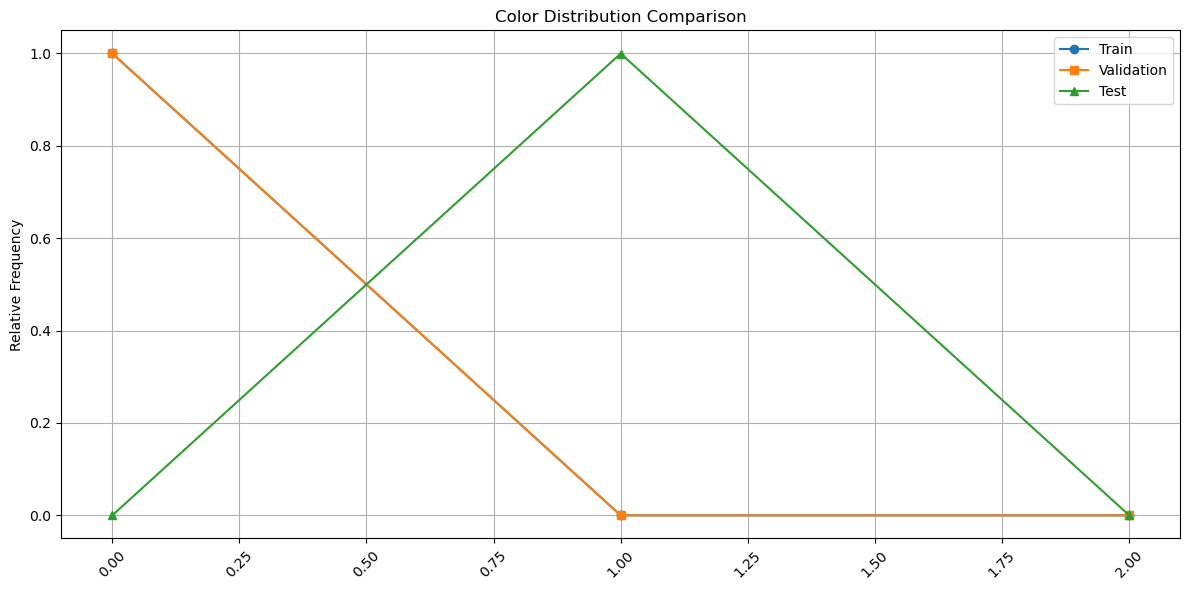

In [102]:
plot_compare_distribution(train_dist=train_gearbox_dist, val_dist=val_gearbox_dist, test_dist=test_gearbox_dist, feature=list(range(gearbox_lengths["Gearbox"] + 1)))

### Train, Val: Price below 16260. Test: Price above 16260

In [123]:
train_price_df, val_price_df, test_price_df = create_shifted_splits(df=full_data_df, 
                                                                   split=[{"Entry_price": ("<=", 16260)}],
                                                                   split_cond="and",
                                                                   ratio=ratio,
                                                                   mode=1)

cat_plus_gen_cols = categorical_columns + ["Genmodel_ID"]
train_price_df, val_price_df, test_price_df, cat_mapping = categorize(train_df=train_price_df,
                                                                     val_df=val_price_df,
                                                                     test_df=test_price_df,
                                                                     categorical_columns=cat_plus_gen_cols)

train_price_df, val_price_df, test_price_df, mean_price, std_price = normalize(train_df=train_price_df,
                                                        val_df=val_price_df,
                                                        test_df=test_price_df,
                                                        continuous_columns=continuous_columns)

train_price_df = reorder_df(df=train_price_df, new_order=reorder_columns)
val_price_df = reorder_df(df=val_price_df, new_order=reorder_columns)
test_price_df = reorder_df(df=test_price_df, new_order=reorder_columns)

display(train_price_df)
display(val_price_df)
display(test_price_df)

Shape of train df:	(29000, 21)
Shape of val df:	(5000, 21)
Shape of test df:	(5000, 21)
Total Size: 39000
Ratio -> Train: 0.74 | Val: 0.13 | Test: 0.13


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
823,0,0,0,0,0.004366,-0.408869,-0.089052,-0.097234,-0.547534,0.300029,...,-1.608311,-0.789320,-1.124034,-0.218854,-1.828071,-1.275708,16_14$$31,0,0,Chevrolet$$Spark$$2011$$Green$$16_14$$31$$imag...
824,1,0,0,0,0.004366,1.107202,-0.089052,-0.090003,-0.751769,0.300029,...,-1.608311,-0.789320,-1.574955,0.464986,-1.297593,-1.336326,16_14$$33,0,45,Chevrolet$$Spark$$2011$$Black$$16_14$$33$$imag...
825,2,0,0,0,0.004366,-0.408869,-0.089052,0.562884,-0.839220,0.300029,...,-1.608311,-0.789320,-0.978822,0.800454,-1.891728,-1.154472,16_14$$40,0,225,Chevrolet$$Spark$$2011$$Silver$$16_14$$40$$ima...
837,3,0,0,0,0.004366,-0.914226,-0.089052,0.554742,-1.067031,0.300029,...,-1.608311,-0.789320,-0.925323,-0.218854,-1.594661,-1.115071,16_14$$73,0,225,Chevrolet$$Spark$$2011$$Blue$$16_14$$73$$image...
840,4,0,0,0,0.004366,-0.408869,-0.089052,-0.122923,-0.662673,0.300029,...,-1.608311,-0.789320,-1.284531,0.452083,-1.516857,-1.199936,16_14$$78,0,0,Chevrolet$$Spark$$2011$$White$$16_14$$78$$imag...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176397,3,4,0,1,0.004366,-2.430297,-1.261643,2.008579,-0.825787,0.300029,...,1.667520,1.709742,0.557365,-0.838180,-0.187125,1.252059,96_9$$448,158,0,Volvo$$V50$$2006$$Blue$$96_9$$448$$image_0.jpg
176399,2,4,0,1,0.004366,0.601845,-1.261643,-0.317560,-0.328222,0.300029,...,1.667520,1.709742,0.886002,-0.747861,-0.668092,1.482407,96_9$$454,158,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg
176400,2,4,0,0,0.004366,1.107202,-1.261643,0.390395,-0.602362,0.300029,...,1.667520,1.084977,0.618506,-1.251064,-0.569069,1.467253,96_9$$458,158,315,Volvo$$V50$$2006$$Silver$$96_9$$458$$image_0.jpg
176401,0,4,0,1,0.004366,1.107202,-1.261643,2.741818,-1.193136,0.300029,...,1.667520,1.709742,1.191711,-0.786569,-0.356878,1.276307,96_9$$480,158,0,Volvo$$V50$$2006$$Green$$96_9$$480$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
817,2,0,0,0,0.004366,0.601845,-0.089052,-1.089484,-0.930235,0.300029,...,-1.608311,-0.789320,-1.238675,0.297252,-1.736121,-1.315110,16_14$$1,0,45,Chevrolet$$Spark$$2011$$Silver$$16_14$$1$$imag...
833,3,0,0,0,0.004366,0.096488,-0.089052,0.421293,-1.014944,0.300029,...,-1.608311,-0.789320,-0.925323,0.297252,-1.637099,-1.312079,16_14$$63,0,135,Chevrolet$$Spark$$2011$$Blue$$16_14$$63$$image...
895,0,0,0,0,0.004366,-0.408869,0.379984,-0.446509,-0.381679,0.300029,...,-1.449863,-0.789320,-1.284531,0.477888,-1.467346,-1.506056,16_14$$47,0,0,Chevrolet$$Spark$$2013$$Green$$16_14$$47$$imag...
896,3,0,0,0,0.004366,-0.408869,0.379984,-0.191139,-0.740804,0.300029,...,-1.449863,-1.414086,-1.269246,0.000491,-1.580515,-1.339357,16_14$$49,0,225,Chevrolet$$Spark$$2013$$Blue$$16_14$$49$$image...
901,2,0,0,0,-2.873281,1.107202,0.379984,-0.321150,-0.669527,0.300029,...,-1.449863,-1.414086,-1.414457,0.077907,-1.693683,-1.469686,16_14$$83,0,0,Chevrolet$$Spark$$2013$$Silver$$16_14$$83$$ima...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176173,7,4,0,1,0.004366,0.601845,-0.792607,0.236112,-0.196908,0.300029,...,1.667520,1.709742,0.687291,-0.541419,-0.646873,1.346017,96_9$$96,158,90,Volvo$$V50$$2008$$Grey$$96_9$$96$$image_1.jpg
176218,3,4,0,1,0.004366,0.601845,-0.792607,2.160283,-0.821675,0.300029,...,1.667520,1.709742,0.725505,-1.354285,-0.081030,1.433913,96_9$$327,158,315,Volvo$$V50$$2008$$Blue$$96_9$$327$$image_0.jpg
176241,1,4,0,1,0.004366,-1.419583,-0.792607,2.463693,-0.739433,0.300029,...,1.667520,2.959274,1.115283,-1.251064,-0.434682,1.509686,96_9$$461,158,0,Volvo$$V50$$2008$$Black$$96_9$$461$$image_0.jpg
176380,3,4,0,1,0.004366,0.601845,-1.261643,0.514920,-0.740804,0.300029,...,1.667520,1.709742,0.794289,-1.018817,-0.533704,1.321770,96_9$$195,158,45,Volvo$$V50$$2006$$Blue$$96_9$$195$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
0,7,5,1,0,0.004366,-1.419583,1.083538,-1.059370,34.075073,0.300029,...,45.893081,14.205056,3.438671,3.058414,2.564288,3.243358,10_3$$1,159,225,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...
4,7,5,1,0,0.004366,0.096488,1.083538,-1.227788,38.189926,0.300029,...,45.893081,14.205056,3.629739,2.813264,2.932087,3.337316,10_3$$12,159,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...
29,7,5,1,1,0.004366,1.107202,1.552575,-1.354208,42.164967,0.300029,...,45.893081,7.957399,3.209389,2.722946,3.151351,3.334285,10_3$$9,159,225,Bentley$$Bentayga$$2018$$Grey$$10_3$$9$$image_...
59,1,5,1,1,0.004366,-0.914226,1.552575,-1.366850,44.769304,0.300029,...,45.893081,7.957399,3.515098,2.929388,2.861356,3.349440,10_3$$83,159,225,Bentley$$Bentayga$$2018$$Black$$10_3$$83$$imag...
72,1,5,1,0,0.004366,-0.914226,1.552575,-1.355978,40.780556,0.300029,...,45.893081,7.957399,3.415742,3.019707,2.642092,3.413088,10_3$$121,159,0,Bentley$$Bentayga$$2018$$Black$$10_3$$121$$ima...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176277,1,4,0,1,0.004366,-0.408869,0.145466,1.907442,-0.189781,0.300029,...,2.992223,0.460211,0.985357,-0.618835,-0.307367,1.282368,96_9$$205,158,0,Volvo$$V50$$2012$$Black$$96_9$$205$$image_0.jpg
176297,2,4,0,1,0.004366,-0.408869,0.145466,0.466248,0.218415,0.300029,...,2.992223,0.460211,0.863074,-0.696251,-0.420536,1.400573,96_9$$436,158,0,Volvo$$V50$$2012$$Silver$$96_9$$436$$image_0.jpg
176345,1,4,0,0,0.004366,0.096488,-1.496161,1.679885,-1.013574,0.300029,...,2.251568,1.084977,1.138212,-0.373685,-0.257856,1.267214,96_9$$255,158,270,Volvo$$V50$$2005$$Black$$96_9$$255$$image_0.jpg
176362,5,4,0,0,0.004366,-0.408869,-1.496161,1.275339,-1.287714,0.300029,...,2.251568,1.084977,1.145854,-0.167243,-0.696384,1.452099,96_9$$403,158,315,Volvo$$V50$$2005$$Red$$96_9$$403$$image_0.jpg


In [124]:
price_lengths = get_lengths(df_list=[train_price_df, val_price_df, test_price_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)

In [125]:
k = 0.1
low_train_price_df, high_train_price_df = create_splitted_train(train_df=train_price_df, low_data_split=k, nclasses=train_price_df["Genmodel_ID"].nunique())
display(low_train_price_df)
display(high_train_price_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
823,0,0,0,0,0.004366,-0.408869,-0.089052,-0.097234,-0.547534,0.300029,...,-1.608311,-0.789320,-1.124034,-0.218854,-1.828071,-1.275708,16_14$$31,0,0,Chevrolet$$Spark$$2011$$Green$$16_14$$31$$imag...
847,3,0,0,0,0.004366,0.601845,-0.089052,-0.792901,-0.464196,0.300029,...,-1.608311,-0.789320,-1.101106,-0.064022,-1.608807,-1.239338,16_14$$107,0,315,Chevrolet$$Spark$$2011$$Blue$$16_14$$107$$imag...
905,2,0,0,0,0.004366,-0.914226,0.379984,-0.064719,-0.766847,0.300029,...,-1.449863,-1.414086,-0.963537,0.735941,-1.601734,-1.330264,16_14$$92,0,0,Chevrolet$$Spark$$2013$$Silver$$16_14$$92$$ima...
915,5,0,0,0,0.004366,0.096488,0.379984,-0.766555,-0.326851,0.300029,...,-1.449863,-0.789320,-1.506170,0.258544,-1.424908,-1.284801,16_14$$154,0,225,Chevrolet$$Spark$$2013$$Red$$16_14$$154$$image...
963,5,0,0,0,0.004366,-0.408869,-0.323570,0.150196,-0.984789,0.300029,...,-1.608311,-0.789320,-1.513813,0.297252,-1.665391,-1.151442,16_14$$39,0,315,Chevrolet$$Spark$$2010$$Red$$16_14$$39$$image_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176021,5,4,1,1,0.004366,1.107202,-0.558088,1.300624,-0.724355,0.300029,...,1.663835,1.709742,0.901287,-0.593030,-0.519558,1.482407,96_9$$162,158,90,Volvo$$V50$$2009$$Red$$96_9$$162$$image_12.jpg
176024,3,4,0,1,0.004366,0.601845,-0.558088,0.617952,-0.148660,0.300029,...,1.663835,0.460211,1.176425,-0.476906,-0.328586,1.273276,96_9$$176,158,0,Volvo$$V50$$2009$$Blue$$96_9$$176$$image_0.jpg
176058,3,4,0,1,0.004366,1.107202,-0.558088,1.601505,-0.600992,0.300029,...,1.663835,0.460211,0.962429,-1.109135,-0.137614,1.470284,96_9$$383,158,315,Volvo$$V50$$2009$$Blue$$96_9$$383$$image_0.jpg
176079,2,4,0,0,0.004366,0.096488,-0.558088,1.654601,-0.739433,0.300029,...,1.663835,0.460211,1.161140,-0.218854,-0.222490,1.315708,96_9$$510,158,135,Volvo$$V50$$2009$$Silver$$96_9$$510$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
824,1,0,0,0,0.004366,1.107202,-0.089052,-0.090003,-0.751769,0.300029,...,-1.608311,-0.789320,-1.574955,0.464986,-1.297593,-1.336326,16_14$$33,0,45,Chevrolet$$Spark$$2011$$Black$$16_14$$33$$imag...
825,2,0,0,0,0.004366,-0.408869,-0.089052,0.562884,-0.839220,0.300029,...,-1.608311,-0.789320,-0.978822,0.800454,-1.891728,-1.154472,16_14$$40,0,225,Chevrolet$$Spark$$2011$$Silver$$16_14$$40$$ima...
837,3,0,0,0,0.004366,-0.914226,-0.089052,0.554742,-1.067031,0.300029,...,-1.608311,-0.789320,-0.925323,-0.218854,-1.594661,-1.115071,16_14$$73,0,225,Chevrolet$$Spark$$2011$$Blue$$16_14$$73$$image...
840,4,0,0,0,0.004366,-0.408869,-0.089052,-0.122923,-0.662673,0.300029,...,-1.608311,-0.789320,-1.284531,0.452083,-1.516857,-1.199936,16_14$$78,0,0,Chevrolet$$Spark$$2011$$White$$16_14$$78$$imag...
843,3,0,0,0,0.004366,0.601845,-0.089052,0.234443,-0.664044,0.300029,...,-1.608311,-1.414086,-0.994108,-0.322075,-1.311739,-1.124163,16_14$$98,0,135,Chevrolet$$Spark$$2011$$Blue$$16_14$$98$$image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176397,3,4,0,1,0.004366,-2.430297,-1.261643,2.008579,-0.825787,0.300029,...,1.667520,1.709742,0.557365,-0.838180,-0.187125,1.252059,96_9$$448,158,0,Volvo$$V50$$2006$$Blue$$96_9$$448$$image_0.jpg
176399,2,4,0,1,0.004366,0.601845,-1.261643,-0.317560,-0.328222,0.300029,...,1.667520,1.709742,0.886002,-0.747861,-0.668092,1.482407,96_9$$454,158,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg
176400,2,4,0,0,0.004366,1.107202,-1.261643,0.390395,-0.602362,0.300029,...,1.667520,1.084977,0.618506,-1.251064,-0.569069,1.467253,96_9$$458,158,315,Volvo$$V50$$2006$$Silver$$96_9$$458$$image_0.jpg
176401,0,4,0,1,0.004366,1.107202,-1.261643,2.741818,-1.193136,0.300029,...,1.667520,1.709742,1.191711,-0.786569,-0.356878,1.276307,96_9$$480,158,0,Volvo$$V50$$2006$$Green$$96_9$$480$$image_0.jpg


In [126]:
price_dir = os.path.join(SHIFTED_DIR, "price")

In [127]:
save_lengths(lengths=price_lengths, file_name="tabular_lengths.pt", save_directory=price_dir)

In [128]:
price_dir = os.path.join(SHIFTED_DIR, "price")

In [129]:
save_dataset(df=train_price_df, save_directory=price_dir, split="train", k="", keep_cols=reorder_columns)
save_dataset(df=low_train_price_df, save_directory=price_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_price_df, save_directory=price_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)
save_dataset(df=val_price_df, save_directory=price_dir, split="val", k="", keep_cols=reorder_columns)
save_dataset(df=test_price_df, save_directory=price_dir, split="test", k="", keep_cols=reorder_columns)

In [130]:
k = 0.01
low_train_price_df, high_train_price_df = create_splitted_train(train_df=train_price_df, low_data_split=k, nclasses=train_price_df["Genmodel_ID"].nunique())
display(low_train_price_df)
display(high_train_price_df)

,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
823,0,0,0,0,0.004366,-0.408869,-0.089052,-0.097234,-0.547534,0.300029,...,-1.608311,-0.789320,-1.124034,-0.218854,-1.828071,-1.275708,16_14$$31,0,0,Chevrolet$$Spark$$2011$$Green$$16_14$$31$$imag...
1001,2,1,0,1,0.004366,-0.914226,0.849020,-0.967892,0.329716,0.300029,...,0.598913,0.460211,-0.092267,1.484294,-0.646873,0.051824,18_10$$64,1,225,Citroen$$C3 Picasso$$2015$$Silver$$18_10$$64$$...
1453,1,0,0,1,0.004366,-0.914226,0.379984,-0.132758,0.070379,0.300029,...,0.943447,0.460211,0.465652,-0.773667,-0.052737,0.818641,18_12$$2,2,225,Citroen$$C4$$2013$$Black$$18_12$$2$$image_1.jpg
2387,8,0,0,1,0.004366,-0.914226,1.083538,-0.936591,1.372822,0.300029,...,0.619180,0.460211,0.351011,0.671428,1.050657,0.357945,18_13$$8,3,0,Citroen$$C4 Cactus$$2016$$Purple$$18_13$$8$$im...
2927,13,1,1,1,0.004366,0.601845,-0.792607,1.123635,-0.532457,0.300029,...,0.912125,0.460211,1.420992,2.155230,0.046285,1.749126,18_14$$27,4,0,Citroen$$C4 Picasso$$2008$$Brown$$18_14$$27$$i...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170513,11,0,0,0,0.004366,-0.408869,1.083538,-1.096816,0.769438,-1.476014,...,-0.898978,-1.414086,-1.146962,-0.825277,0.753590,-1.542427,95_33$$732,154,225,Volkswagen$$up!$$2016$$Yellow$$95_33$$732$$ima...
171060,4,2,0,0,0.004366,-0.408869,-0.558088,2.488977,-0.875407,-1.476014,...,1.179646,1.084977,0.626149,-0.360782,-0.455901,0.733776,96_1$$11,155,270,Volvo$$C30$$2009$$White$$96_1$$11$$image_0.jpg
174432,1,3,0,0,0.004366,-0.408869,-0.792607,0.592668,-0.602362,0.300029,...,0.840271,0.460211,0.832503,-1.186551,-0.448828,1.342986,96_3$$9,156,315,Volvo$$S40$$2008$$Black$$96_3$$9$$image_0.jpg
175792,3,4,0,1,0.004366,-0.914226,-2.199715,1.874573,-1.289085,0.300029,...,1.440901,1.397360,-0.008197,-0.760764,-0.427609,1.527871,96_7$$150,157,315,Volvo$$V40$$2002$$Blue$$96_7$$150$$image_0.jpg


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Adv_ID,Genmodel_ID,Predicted_viewpoint,Image_name
824,1,0,0,0,0.004366,1.107202,-0.089052,-0.090003,-0.751769,0.300029,...,-1.608311,-0.789320,-1.574955,0.464986,-1.297593,-1.336326,16_14$$33,0,45,Chevrolet$$Spark$$2011$$Black$$16_14$$33$$imag...
825,2,0,0,0,0.004366,-0.408869,-0.089052,0.562884,-0.839220,0.300029,...,-1.608311,-0.789320,-0.978822,0.800454,-1.891728,-1.154472,16_14$$40,0,225,Chevrolet$$Spark$$2011$$Silver$$16_14$$40$$ima...
837,3,0,0,0,0.004366,-0.914226,-0.089052,0.554742,-1.067031,0.300029,...,-1.608311,-0.789320,-0.925323,-0.218854,-1.594661,-1.115071,16_14$$73,0,225,Chevrolet$$Spark$$2011$$Blue$$16_14$$73$$image...
840,4,0,0,0,0.004366,-0.408869,-0.089052,-0.122923,-0.662673,0.300029,...,-1.608311,-0.789320,-1.284531,0.452083,-1.516857,-1.199936,16_14$$78,0,0,Chevrolet$$Spark$$2011$$White$$16_14$$78$$imag...
843,3,0,0,0,0.004366,0.601845,-0.089052,0.234443,-0.664044,0.300029,...,-1.608311,-1.414086,-0.994108,-0.322075,-1.311739,-1.124163,16_14$$98,0,135,Chevrolet$$Spark$$2011$$Blue$$16_14$$98$$image...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176397,3,4,0,1,0.004366,-2.430297,-1.261643,2.008579,-0.825787,0.300029,...,1.667520,1.709742,0.557365,-0.838180,-0.187125,1.252059,96_9$$448,158,0,Volvo$$V50$$2006$$Blue$$96_9$$448$$image_0.jpg
176399,2,4,0,1,0.004366,0.601845,-1.261643,-0.317560,-0.328222,0.300029,...,1.667520,1.709742,0.886002,-0.747861,-0.668092,1.482407,96_9$$454,158,0,Volvo$$V50$$2006$$Silver$$96_9$$454$$image_0.jpg
176400,2,4,0,0,0.004366,1.107202,-1.261643,0.390395,-0.602362,0.300029,...,1.667520,1.084977,0.618506,-1.251064,-0.569069,1.467253,96_9$$458,158,315,Volvo$$V50$$2006$$Silver$$96_9$$458$$image_0.jpg
176401,0,4,0,1,0.004366,1.107202,-1.261643,2.741818,-1.193136,0.300029,...,1.667520,1.709742,1.191711,-0.786569,-0.356878,1.276307,96_9$$480,158,0,Volvo$$V50$$2006$$Green$$96_9$$480$$image_0.jpg


In [131]:
save_dataset(df=low_train_price_df, save_directory=price_dir, split="train", k="_"+str(k), keep_cols=reorder_columns)
save_dataset(df=high_train_price_df, save_directory=price_dir, split="train", k="_"+str(1-k), keep_cols=reorder_columns)

In [140]:
train_price_denorm_df = denormalize_column(df=train_price_df, column="Entry_price", means=mean_price, stds=std_price)
val_price_denorm_df = denormalize_column(df=val_price_df, column="Entry_price", means=mean_price, stds=std_price)
test_price_denorm_df = denormalize_column(df=test_price_df, column="Entry_price", means=mean_price, stds=std_price)
train_price_denorm_df

0         6890.0
1         6890.0
2         6890.0
3         6890.0
4         6890.0
          ...   
28995    15780.0
28996    15780.0
28997    15780.0
28998    15780.0
28999    15780.0
Name: Entry_price, Length: 29000, dtype: float64

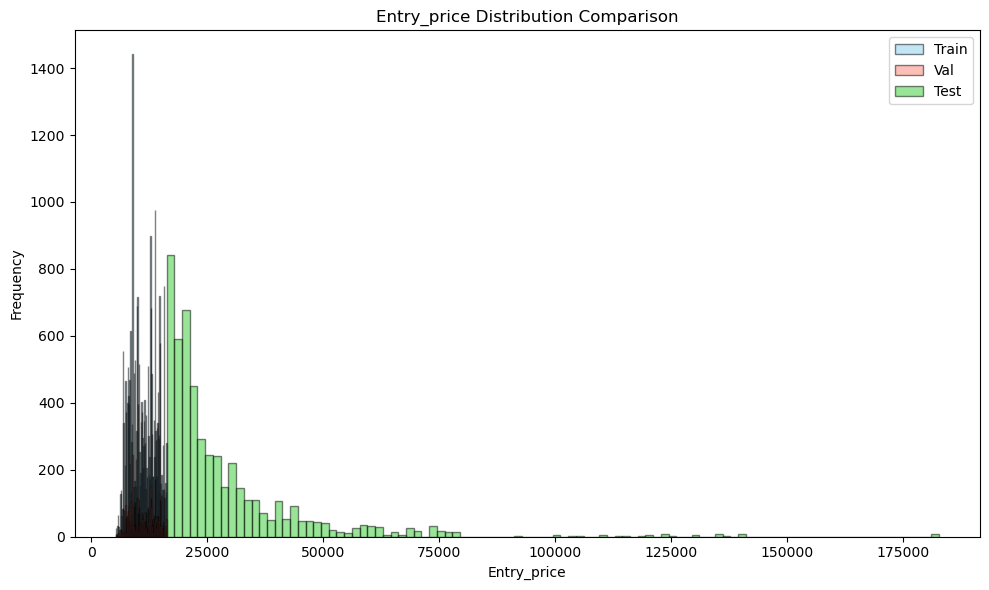

In [143]:
plot_distributions_compare(train_df=train_price_denorm_df, val_df=val_price_denorm_df, test_df=test_price_denorm_df, feature="Entry_price", bins=100)

In [ ]:
#all_lables_path = os.path.join(SHIFTED_DIR, "labels_only_black_train.pt")
#all_unlables_path = os.path.join(SHIFTED_DIR, "labels_only_black_test.pt")
#
#label_data = torch.load(all_lables_path, map_location='cpu')
#
#unlabel_data = torch.load(all_unlables_path, map_location='cpu')
#
#from collections import Counter
#label_counts = Counter(label_data)
#unlabel_counts = Counter(unlabel_data)
#
## Get sorted list of all label IDs (for alignment)
#all_labels = sorted(set(label_counts.keys()) | set(unlabel_counts.keys()))
#
## Create aligned frequency arrays
#label_freqs = np.array([label_counts.get(l, 0) for l in all_labels])
#unlabel_freqs = np.array([unlabel_counts.get(l, 0) for l in all_labels])
#
#label_freqs_norm = label_freqs / label_freqs.sum()
#unlabel_freqs_norm = unlabel_freqs / unlabel_freqs.sum()
#
#print(f"Jensen-Shannon Divergence: {jensenshannon(label_freqs_norm, unlabel_freqs_norm)}")
#print(f"KL-Divergence: {sum(kl_div(label_freqs_norm, unlabel_freqs_norm))}")
#
#
#plt.figure(figsize=(18, 6))
#plt.plot(all_labels, label_freqs_norm, label="Labeled", marker='o')
#plt.plot(all_labels, unlabel_freqs_norm, label="Unlabeled", marker='x')
#plt.title("Label Distribution: Labeled vs Unlabeled")
#plt.xlabel("Label ID")
#plt.ylabel("Frequency")
#plt.legend()
#plt.grid(True)
#plt.tight_layout()
#plt.show()